In [31]:
# Imports :

import numpy as np
import pandas as pd
import string 
import pickle

# Plot : 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import BayesSearchCV

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer

# Utils for classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
from sklearn.ensemble import HistGradientBoostingClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import rewrite_keys, rapport_metrics_decision_tree
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

# Custom utils  
from Opti_utils.ML_utils import find_best_threshold, from_model_to_bst_trhld, custom_metrics, scores, compare_results,find_error
from Opti_utils.ML_utils import FP, TP, FN, TN, check_corr_col, filtre_list, fit_method, check_baseline, check_FP_FN, check_best_results
from Opti_utils.ML_utils import ML_opti_recueil, univariate_ml, sensi, speci, mix_sensi_speci, custom_metric
from Opti_utils.ML_utils import Binarisation, model_to_plot, clean_lists

# Ouverture des datas : 

In [32]:
pwd

'/home/nounou/endopath'

In [33]:
recueil_imc  = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
recueil_imc.shape

(181, 90)

In [34]:
# On enlève les colonnes liés a la chirurgie : 
liste_colonnes_chir = ['date.chir', 'chir.macro.lusd', 'chir.macro.lusg', 'chir.macro.torus',  'chir.macro.oma', 'chir.macro.uro', 'chir.macro.dig',  'chir.macro.superf', 'resec.lusd', 'resec.lusg', 'resec.torus', 'resec.autre']
for col_to_drop in liste_colonnes_chir:
    recueil_imc = recueil_imc.drop(col_to_drop, axis=1)
# Remplace les manquantes par un np.nan
recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)
# n_ano en Index
recueil_imc = recueil_imc.set_index('Numéro anonymat')
recueil_imc.shape

/tmp/ipykernel_14395/2947652957.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)


(181, 77)

# Split des features et des targets : 

In [35]:
# recueil_imc.dropna(axis=0, inplace=True)
target = recueil_imc.iloc[:,-4:].copy()
features = recueil_imc.iloc[:,:-4].copy()

endometriose = target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))

recueil_imc_endo = recueil_imc.copy()
recueil_imc_endo['endometriose'] = endometriose
recueil_imc_endo.shape

(181, 78)

## Préparation des données : 

In [36]:
features_chir_ONE = pd.get_dummies(features.loc[:,'chir'], prefix='chir')
features_dsptype_ONE = pd.get_dummies(features.loc[:,'sf.dsp.type'].replace(0, 'aucun'), prefix='dsp.type')
features_enc = pd.concat([features.drop('chir', axis=1).drop('sf.dsp.type', axis=1), features_chir_ONE, features_dsptype_ONE], axis=1)

In [37]:
# split 
X_train, X_test, y_train, y_test = train_test_split(features_enc, endometriose, random_state=42, stratify=endometriose)



In [38]:
# Préparation des métriques :
scorer = make_scorer(custom_metric, greater_is_better=True)
mix_recall = make_scorer(mix_sensi_speci, greater_is_better=True)
sensibilite = make_scorer(sensi, greater_is_better=True)
specificite = make_scorer(speci, greater_is_better=True)
scorers = { 'speci': specificite, 'sensi' : sensibilite}

## Préparation du ML univarié : 

## Résultats : 

In [39]:
with open('Data/DATA_PROCESSED/data.pkl', 'rb') as f1:
    dictionnary_list = pickle.load(f1)
    
liste_col_speci= dictionnary_list['specifite']
liste_col_sensi = dictionnary_list['sensibilite']
liste_col_mixte = dictionnary_list['moyenne']

In [40]:
liste_col_sensi = clean_lists(liste_col_sensi)
liste_col_speci = clean_lists(liste_col_speci)
liste_col_mixte = clean_lists(liste_col_mixte)

## Save Results

# Essais de ML avec les colonnes :

In [41]:
seed = 42 

In [42]:
## Init Metrics :
scorer = make_scorer(custom_metric, greater_is_better=True)
mix_recall = make_scorer(mix_sensi_speci, greater_is_better=True)
sensibilite = make_scorer(sensi, greater_is_better=True)
specificite = make_scorer(speci, greater_is_better=True)

In [43]:
# Paramètres pour la BayesSearch
param_hi={}
param_hi['loss'] = ['log_loss']
param_hi['max_depth'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
param_hi['max_iter'] = [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
param_hi['learning_rate'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_hi['l2_regularization'] = [0.0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4]

## Base line : 

In [102]:
# Copy the original datasets
X_train_ = X_train.copy()
X_test_ = X_test.copy()

# List of columns to drop due to high correlation
liste_to_drop = ['p', 'atcd.chir.endo', 'atcd.infertilite', 'sf.dsm', 'sf.dsp', 'ef.hormone.dsm', 'echo.oma', 'irm.xr']

# Drop the correlated columns
for col in liste_to_drop:
    if col in X_train_.columns:
        X_train_.drop(col, axis=1, inplace=True)
    if col in X_test_.columns:
        X_test_.drop(col, axis=1, inplace=True)

# Print columns after dropping correlated columns
print("Columns in X_train_ after dropping correlated columns:", list(X_train_.columns))
print("Columns in X_test_ after dropping correlated columns:", list(X_test_.columns))

Columns in X_train_ after dropping correlated columns: ['age', 'imc', 'g', 'atcd.endo', 'atcd.chir.oma', 'atcd.fibrome', 'atcd.pma', 'atcd.fiv', 'desir.G', 'atcd.sma.douleur', 'atcd.hospit.douleur', 'atcd.absenteisme', 'ttt.op', 'ttt.p', 'ttt.ains', 'ttt.p1', 'ttt.p2', 'ttt.p3', 'sf.dsm.type', 'sf.dsm.eva', 'sf.dpc', 'sf.dsp.eva', 'sf.dig.diarrhee', 'sf.dig.constip', 'sf.dig.rectorragie', 'sf.uro', 'sf.scap', 'sf.ombilic', 'effet.hormone', 'ef.hormone.dsp', 'ef.hormone.dpc', 'effet.hormone.dig', 'tv.douloureux', 'tv.douleur.lusd', 'tv.douleur.lusg', 'tv.douleur.torus', 'tv.nodule.lusd', 'tv.nodule.lusg', 'tv.nodule.torus', 'spec.nodule', 'echo.adm', 'echo.noduleRV', 'echo.lusd', 'echo.lusg', 'echo.torus', 'echo.rectum', 'echo.sigmoide', 'irm.endo', 'irm.adm', 'irm.lusd', 'irm.lusg', 'irm.torus', 'irm.oma', 'irm.dig', 'irm.vagin', 'irm.kissing', 'irm.adherences', 'irm.retroversion', 'irm.epanchement', 'irm.opac.vagin', 'irm.opac.rectum', 'irm.externe', 'avis.dig/uro', 'chir_BC', 'chir_C

### HI

In [45]:
# Création de la liste des catégorielles pour le HGB
list_type_variable = []
for name, series in X_train_.items():
    if len(series.value_counts())<=2:
        list_type_variable.append(True)
    else :
        list_type_variable.append(False) 

In [46]:
# Init du modèle :
HI_baseline = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
# Préparation des datas :

# Entrainement :
baseline_HGB_cv = cross_validate(HI_baseline, X_train_, y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(baseline_HGB_cv['test_sensi'].mean(), 2))
print('speci : ',round(baseline_HGB_cv['test_speci'].mean(),2))

sensi :  0.58
speci :  0.48


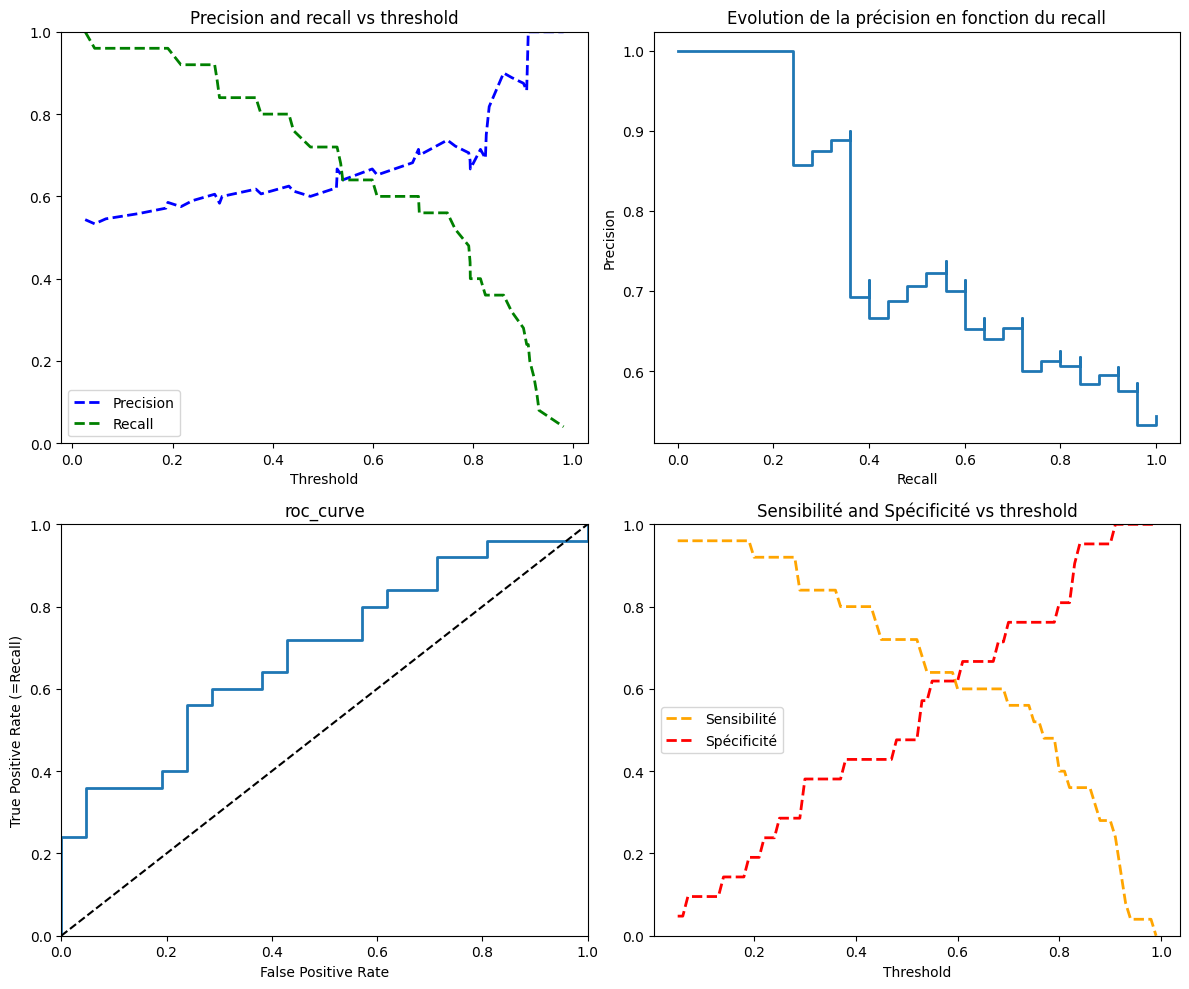

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.8
Sensibilité : 0.4
Spécificité : 0.8095238095238095


In [47]:
# Init du modèle :
HI_baseline_ = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
# Préparation des datas :
HI_baseline_.fit(X_train_, y_train)
# Results :
pred_bl1 = HI_baseline_.predict(X_test_)
model_to_plot(HI_baseline_, X_test_, y_test)
resultat_bl1 = pd.DataFrame(pd.Series(scores(y_test, pred_bl1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl1.loc['specificité','XGB_BL_sensi'])
dict_bl_1 = from_model_to_bst_trhld(HI_baseline_, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_bl_1['best_threshold'])
print('Sensibilité :', dict_bl_1['scores']['sensibilite'])
print('Spécificité :', dict_bl_1['scores']['specificité'])

### <u>Optimisation Baseline</u> : 

#### Sensi :

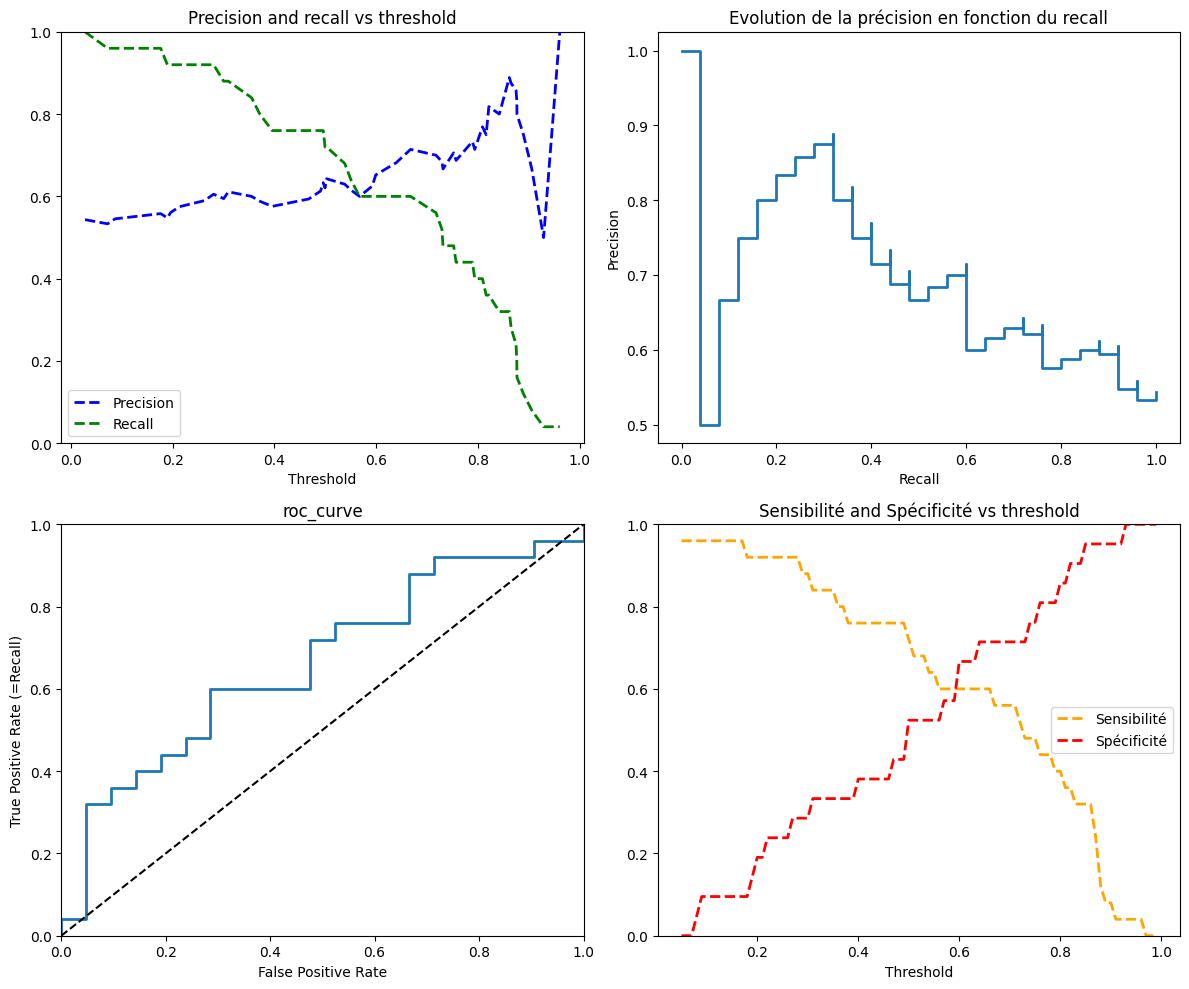

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.76
Sensibilité : 0.44
Spécificité : 0.8095238095238095


In [48]:
hi_1_opti = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs_1 = BayesSearchCV(hi_1_opti, param_hi, scoring=sensibilite, random_state=seed)
bs_1.fit(X_train_, y_train)
tree_bl_1 = HistGradientBoostingClassifier(**dict(bs_1.best_params_),random_state=seed, categorical_features=list_type_variable)
tree_bl_1.fit(X_train_, y_train)
# Results :
pred_bl1 = tree_bl_1.predict(X_test_)
model_to_plot(tree_bl_1, X_test_, y_test)
resultat_bl1 = pd.DataFrame(pd.Series(scores(y_test, pred_bl1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl1.loc['specificité','XGB_BL_sensi'])
dict_bl_1 = from_model_to_bst_trhld(tree_bl_1, X_test_, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_bl_1['best_threshold'])
print('Sensibilité :', dict_bl_1['scores']['sensibilite'])
print('Spécificité :', dict_bl_1['scores']['specificité'])

#### Spéci :

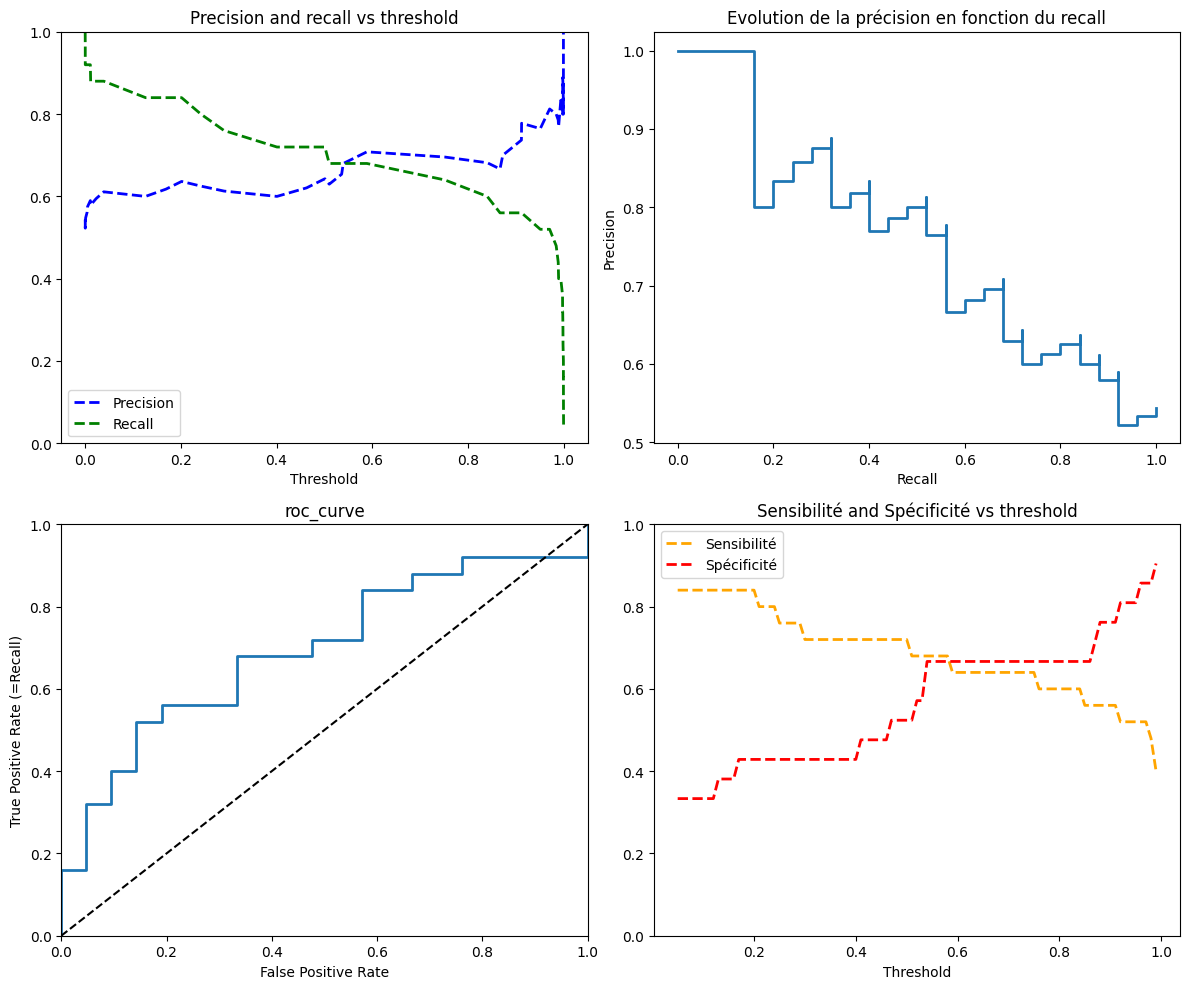

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.96
Sensibilité : 0.52
Spécificité : 0.8571428571428571


In [49]:
hi_2_opti = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs2 = BayesSearchCV(hi_2_opti, param_hi, scoring=specificite, random_state=seed)
bs2.fit(X_train_, y_train)
tree_bl_2 = HistGradientBoostingClassifier(**dict(bs2.best_params_),random_state=seed, categorical_features=list_type_variable)
tree_bl_2.fit(X_train_, y_train)
# Results :
pred_bl2 = tree_bl_2.predict(X_test_)
model_to_plot(tree_bl_2, X_test_, y_test)
resultat_bl2 = pd.DataFrame(pd.Series(scores(y_test, pred_bl2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl2.loc['specificité','XGB_BL_sensi'])
dict_bl_2 = from_model_to_bst_trhld(tree_bl_2, X_test_, y_test)
if dict_bl_2:
    print('_________________________________________________________')
    print('Best threshold :', dict_bl_2['best_threshold'])
    print('Sensibilité :', dict_bl_2['scores']['sensibilite'])
    print('Spécificité :', dict_bl_2['scores']['specificité'])

#### F1 :

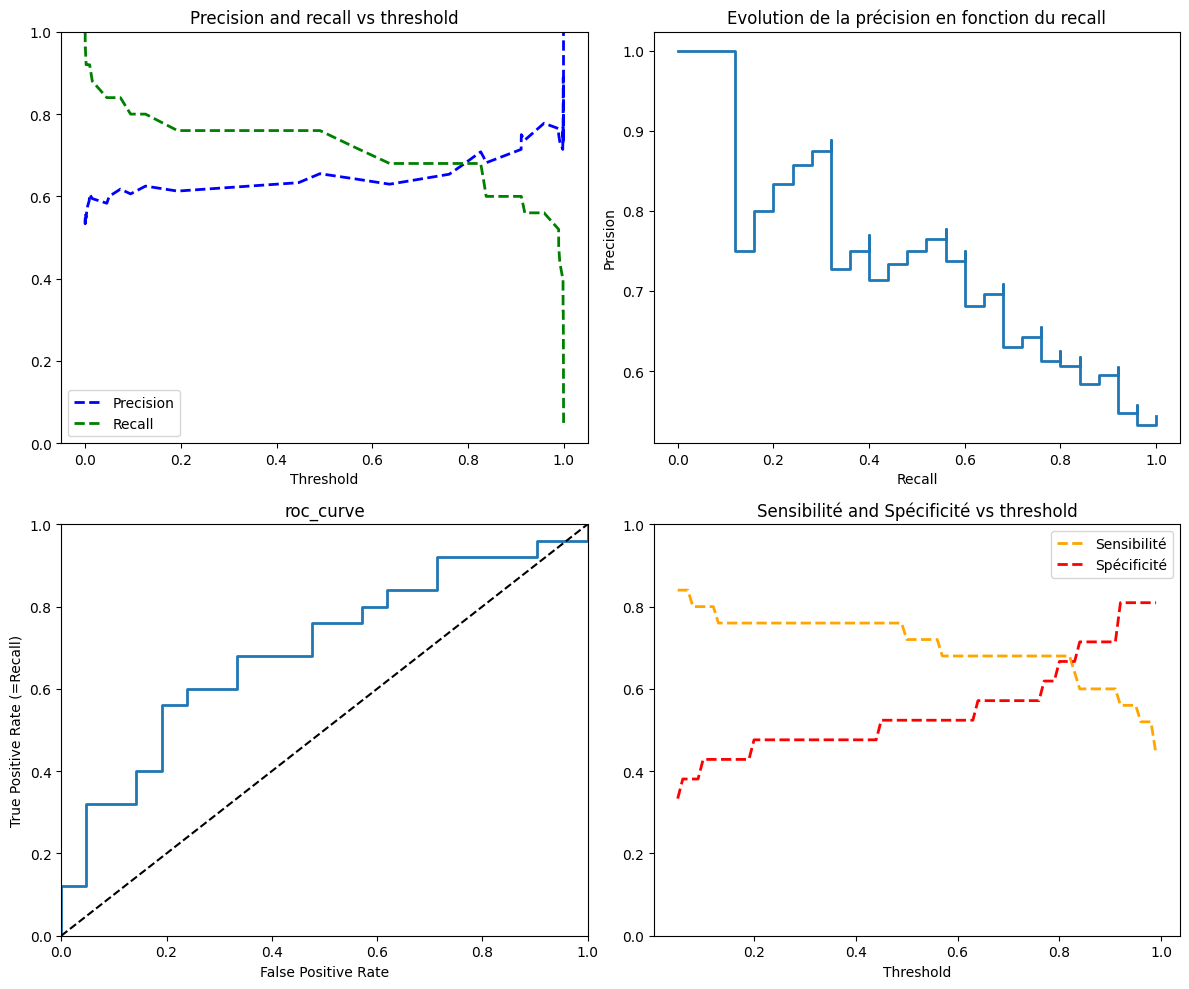

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.92
Sensibilité : 0.56
Spécificité : 0.8095238095238095


In [50]:
hi_3_opti = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs3 = BayesSearchCV(hi_3_opti, param_hi, scoring='f1', random_state=seed)
bs3.fit(X_train_, y_train)
tree_bl_3 =  HistGradientBoostingClassifier(**dict(bs3.best_params_),random_state=seed, categorical_features=list_type_variable)
tree_bl_3.fit(X_train_, y_train)
# Results :
pred_bl3 = tree_bl_3.predict(X_test_)
model_to_plot(tree_bl_3, X_test_, y_test)
resultat_bl3 = pd.DataFrame(pd.Series(scores(y_test, pred_bl3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl3.loc['specificité','XGB_BL_sensi'])
dict_bl_3 = from_model_to_bst_trhld(tree_bl_3, X_test_, y_test)
if dict_bl_3:
    print('_________________________________________________________')
    print('Best threshold :', dict_bl_3['best_threshold'])
    print('Sensibilité :', dict_bl_3['scores']['sensibilite'])
    print('Spécificité :', dict_bl_3['scores']['specificité'])

#### Custom :

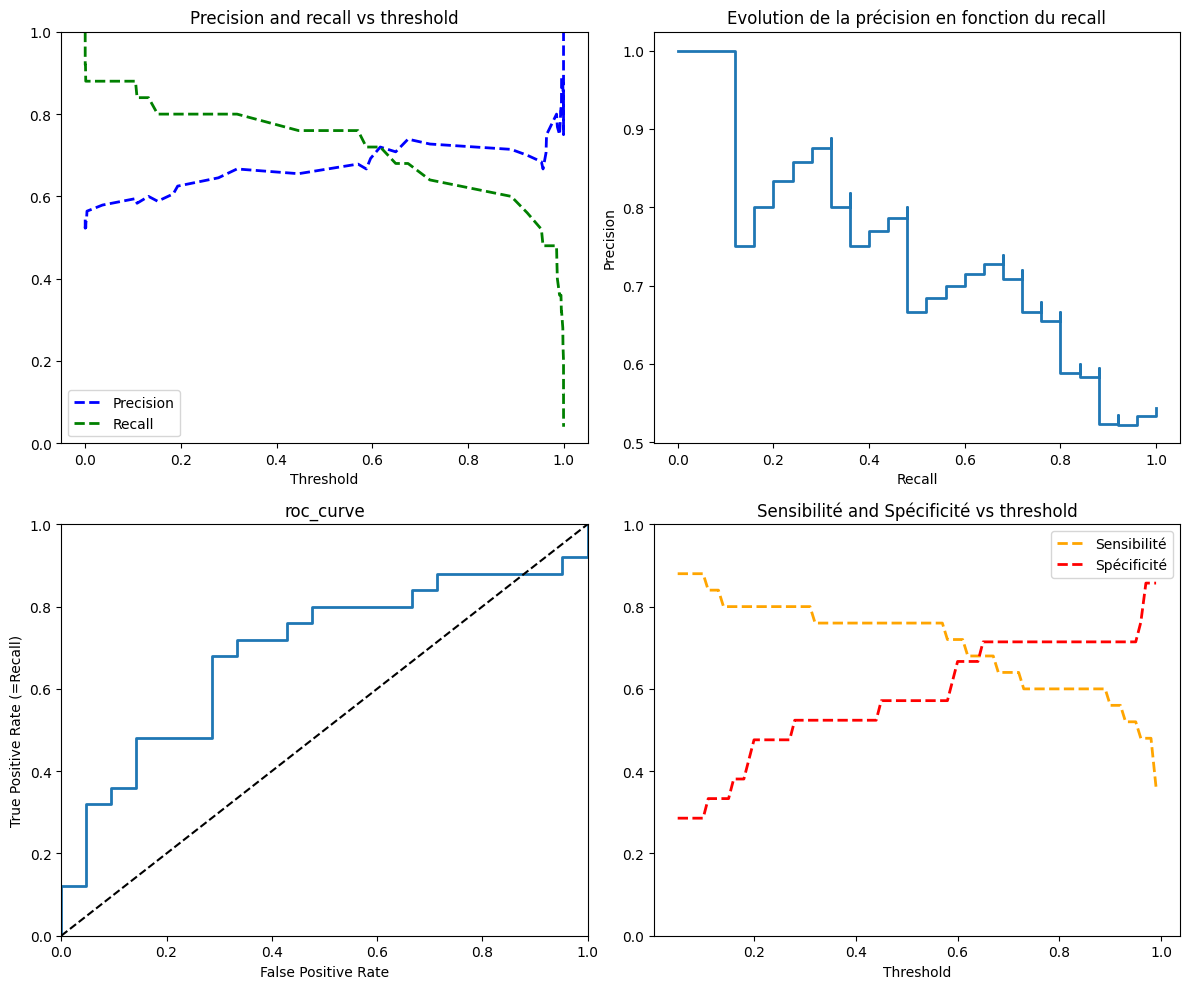

threshold = 0,5
Sensibilité :  0.76
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.97
Sensibilité : 0.48
Spécificité : 0.8571428571428571


In [51]:
hi_4_opti = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs4 = BayesSearchCV(hi_4_opti, param_hi, scoring=scorer, random_state=seed)
bs4.fit(X_train_, y_train)
tree_bl_4 = HistGradientBoostingClassifier(**dict(bs4.best_params_),random_state=seed, categorical_features=list_type_variable)
tree_bl_4.fit(X_train_, y_train)
# Results :
pred_bl4 = tree_bl_4.predict(X_test_)
model_to_plot(tree_bl_4, X_test_, y_test)
resultat_bl4 = pd.DataFrame(pd.Series(scores(y_test, pred_bl4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl4.loc['specificité','XGB_BL_sensi'])
dict_bl_4 = from_model_to_bst_trhld(tree_bl_4, X_test_, y_test)
if dict_bl_4:
    print('_________________________________________________________')
    print('Best threshold :', dict_bl_4['best_threshold'])
    print('Sensibilité :', dict_bl_4['scores']['sensibilite'])
    print('Spécificité :', dict_bl_4['scores']['specificité'])

#### Mix :

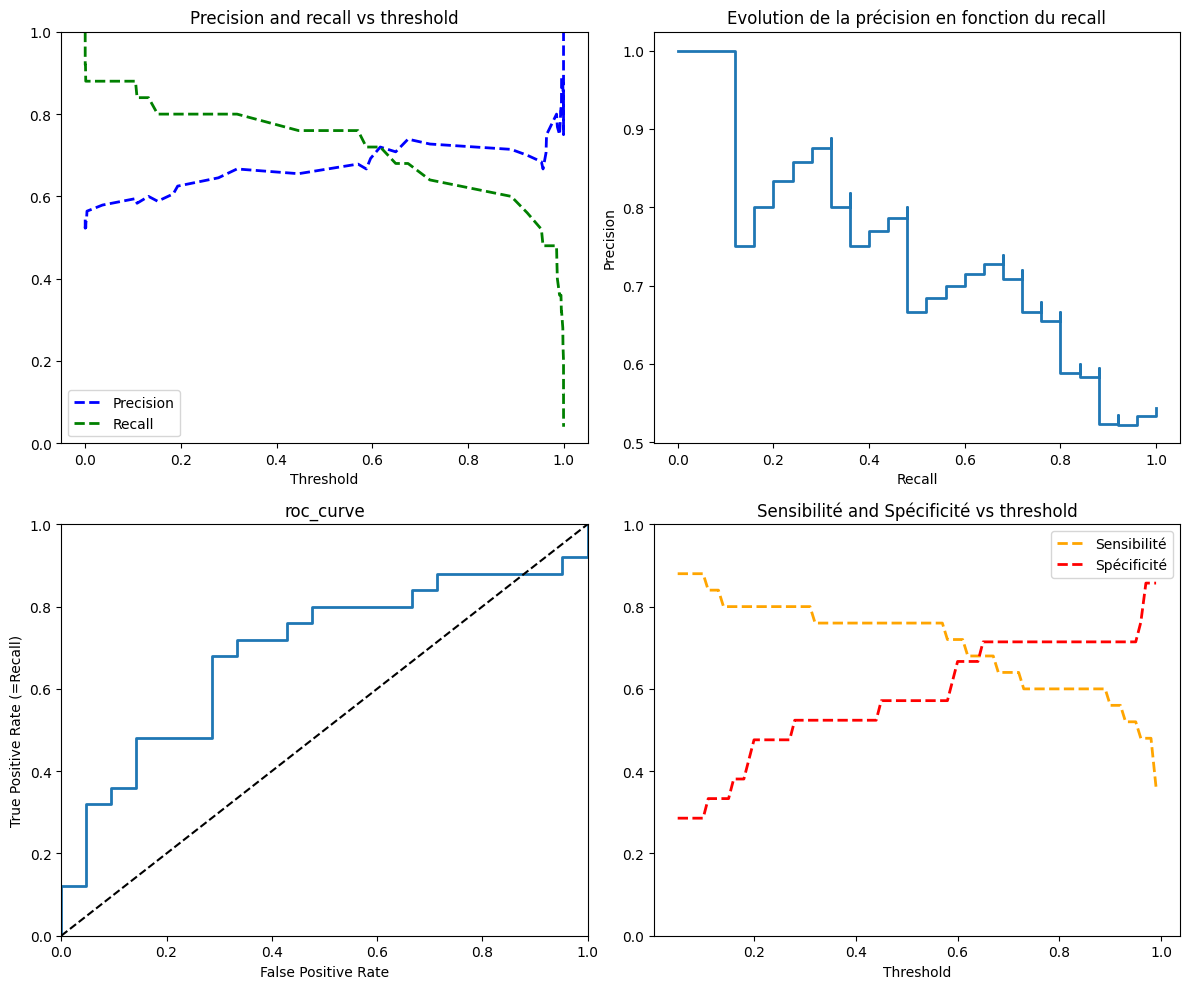

threshold = 0,5
Sensibilité :  0.76
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.97
Sensibilité : 0.48
Spécificité : 0.8571428571428571


In [52]:
hi_5_opti = HistGradientBoostingClassifier(random_state=seed,  categorical_features=list_type_variable)
bs5 = BayesSearchCV(hi_5_opti, param_hi, scoring=mix_recall, random_state=seed)
bs5.fit(X_train_, y_train)
tree_bl_5 = HistGradientBoostingClassifier(**dict(bs5.best_params_),random_state=seed, categorical_features=list_type_variable)
tree_bl_5.fit(X_train_, y_train)
# Results :
pred_bl5 = tree_bl_5.predict(X_test_)
model_to_plot(tree_bl_5, X_test_, y_test)
resultat_bl5 = pd.DataFrame(pd.Series(scores(y_test, pred_bl5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl5.loc['specificité','XGB_BL_sensi'])
dict_bl_5 = from_model_to_bst_trhld(tree_bl_5, X_test_, y_test)
if dict_bl_5:
    print('_________________________________________________________')
    print('Best threshold :', dict_bl_5['best_threshold'])
    print('Sensibilité :', dict_bl_5['scores']['sensibilite'])
    print('Spécificité :', dict_bl_5['scores']['specificité'])

#### average precision

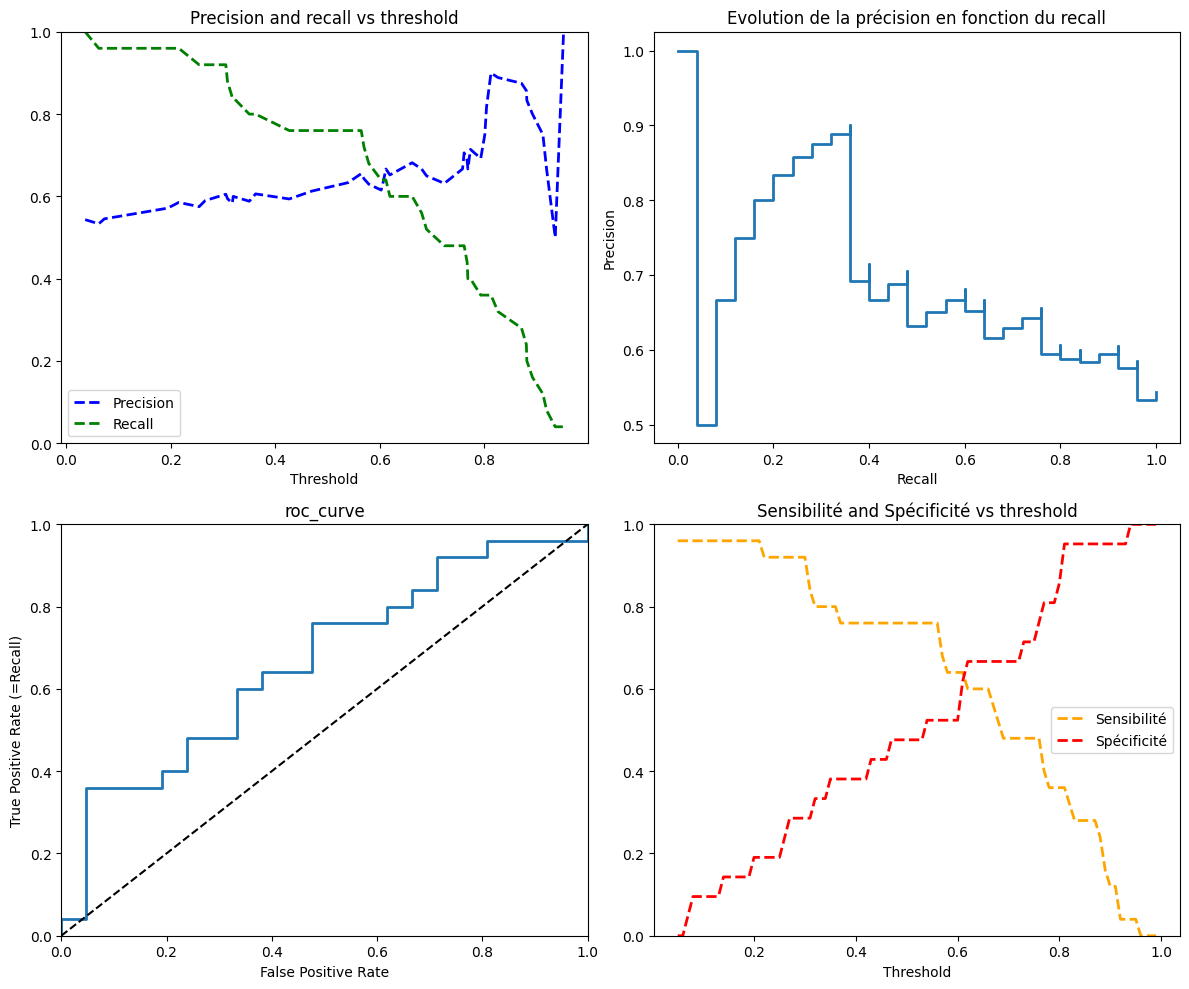

threshold = 0,5
Sensibilité :  0.76
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.77
Sensibilité : 0.4
Spécificité : 0.8095238095238095


In [53]:
hi_6_opti = HistGradientBoostingClassifier(random_state=seed,  categorical_features=list_type_variable)
bs6 = BayesSearchCV(hi_6_opti, param_hi, scoring='average_precision', random_state=seed)
bs6.fit(X_train_, y_train)
tree_bl_6 = HistGradientBoostingClassifier(**dict(bs6.best_params_),random_state=seed, categorical_features=list_type_variable)
tree_bl_6.fit(X_train_, y_train)
# Results :
pred_bl6 = tree_bl_6.predict(X_test_)
model_to_plot(tree_bl_6, X_test_, y_test)
resultat_bl6 = pd.DataFrame(pd.Series(scores(y_test, pred_bl6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl6.loc['specificité','XGB_BL_sensi'])
dict_bl_6 = from_model_to_bst_trhld(tree_bl_6, X_test_, y_test)
if dict_bl_6:
    print('_________________________________________________________')
    print('Best threshold :', dict_bl_6['best_threshold'])
    print('Sensibilité :', dict_bl_6['scores']['sensibilite'])
    print('Spécificité :', dict_bl_6['scores']['specificité'])

## ML sensibilité : 

### HI

In [55]:
list_type_variable_sensi = []
for name, series in X_train.loc[:,liste_col_sensi].items():
    if len(series.value_counts())<=2:
        list_type_variable_sensi.append(True)
    else :
        list_type_variable_sensi.append(False) 

In [56]:
# Init du modèle :
HI_sensi = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_sensi)
# Préparation des datas :

# Entrainement :
HGB_sensi_cv = cross_validate(HI_sensi, X_train.loc[:,liste_col_sensi], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(HGB_sensi_cv['test_sensi'].mean(), 2))
print('speci : ',round(HGB_sensi_cv['test_speci'].mean(),2))

sensi :  0.6
speci :  0.56


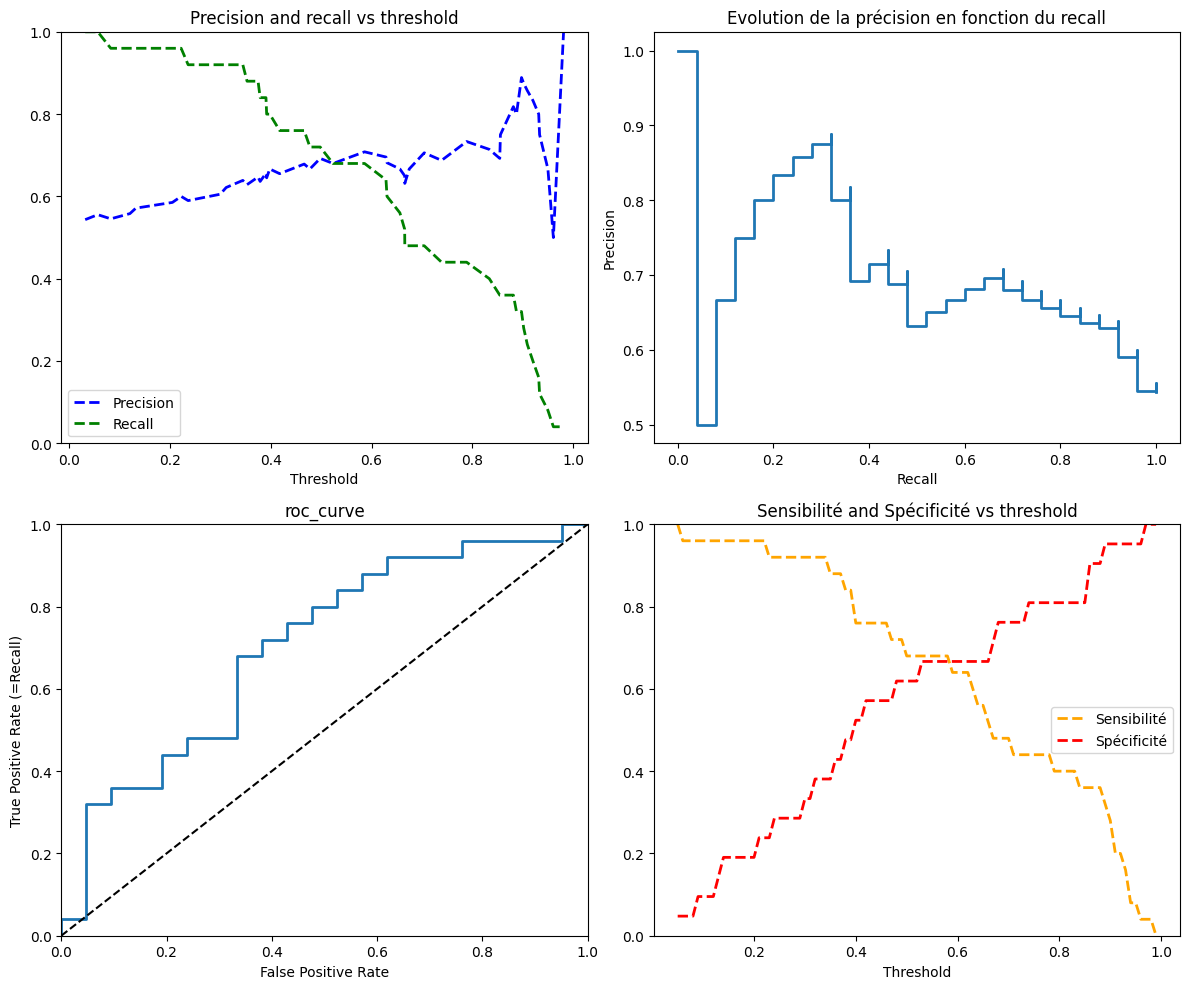

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.74
Sensibilité : 0.44
Spécificité : 0.8095238095238095


In [57]:
# Init du modèle :
HI_sensi = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_sensi)
# Préparation des datas :
HI_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_bl_sensi = HI_sensi.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(HI_sensi, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi = pd.DataFrame(pd.Series(scores(y_test, pred_bl_sensi)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi.loc['specificité','XGB_BL_sensi'])
dict_sensi = from_model_to_bst_trhld(HI_sensi, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi['best_threshold'])
print('Sensibilité :', dict_sensi['scores']['sensibilite'])
print('Spécificité :', dict_sensi['scores']['specificité'])

### Opti : 

#### Sensi :

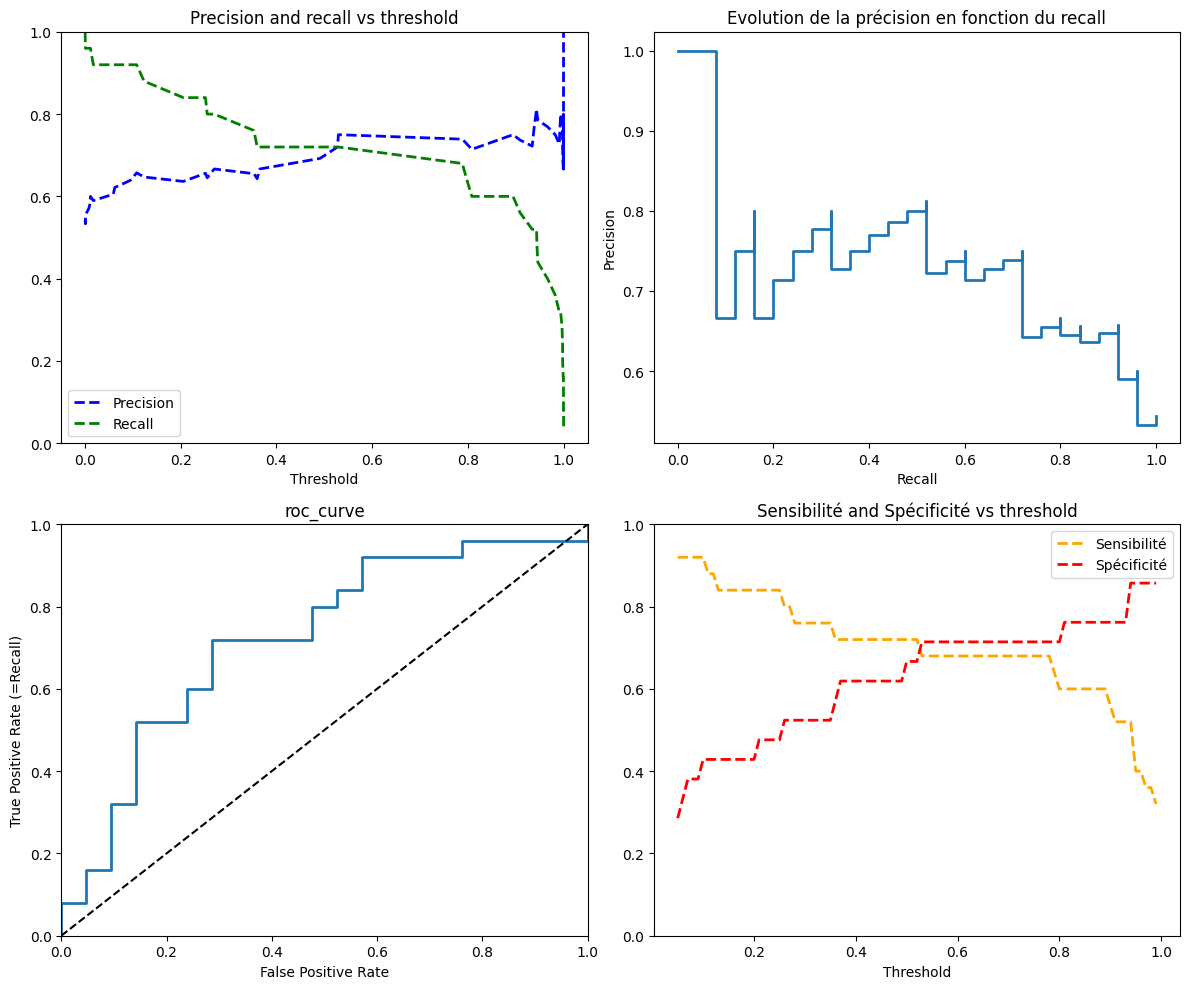

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.52
Spécificité : 0.8571428571428571


In [58]:
hi_1_opti_sensi = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_sensi)
bs_1_sensi = BayesSearchCV(hi_1_opti_sensi, param_hi, scoring=sensibilite, random_state=seed)
bs_1_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_sensi_1 = HistGradientBoostingClassifier(**dict(bs_1_sensi.best_params_),random_state=seed, categorical_features=list_type_variable_sensi)
tree_sensi_1.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_1 = tree_sensi_1.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_1, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi_1 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_1.loc['specificité','XGB_BL_sensi'])
dict_sensi_1 = from_model_to_bst_trhld(tree_sensi_1, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_1['best_threshold'])
print('Sensibilité :', dict_sensi_1['scores']['sensibilite'])
print('Spécificité :', dict_sensi_1['scores']['specificité'])

#### Spéci :

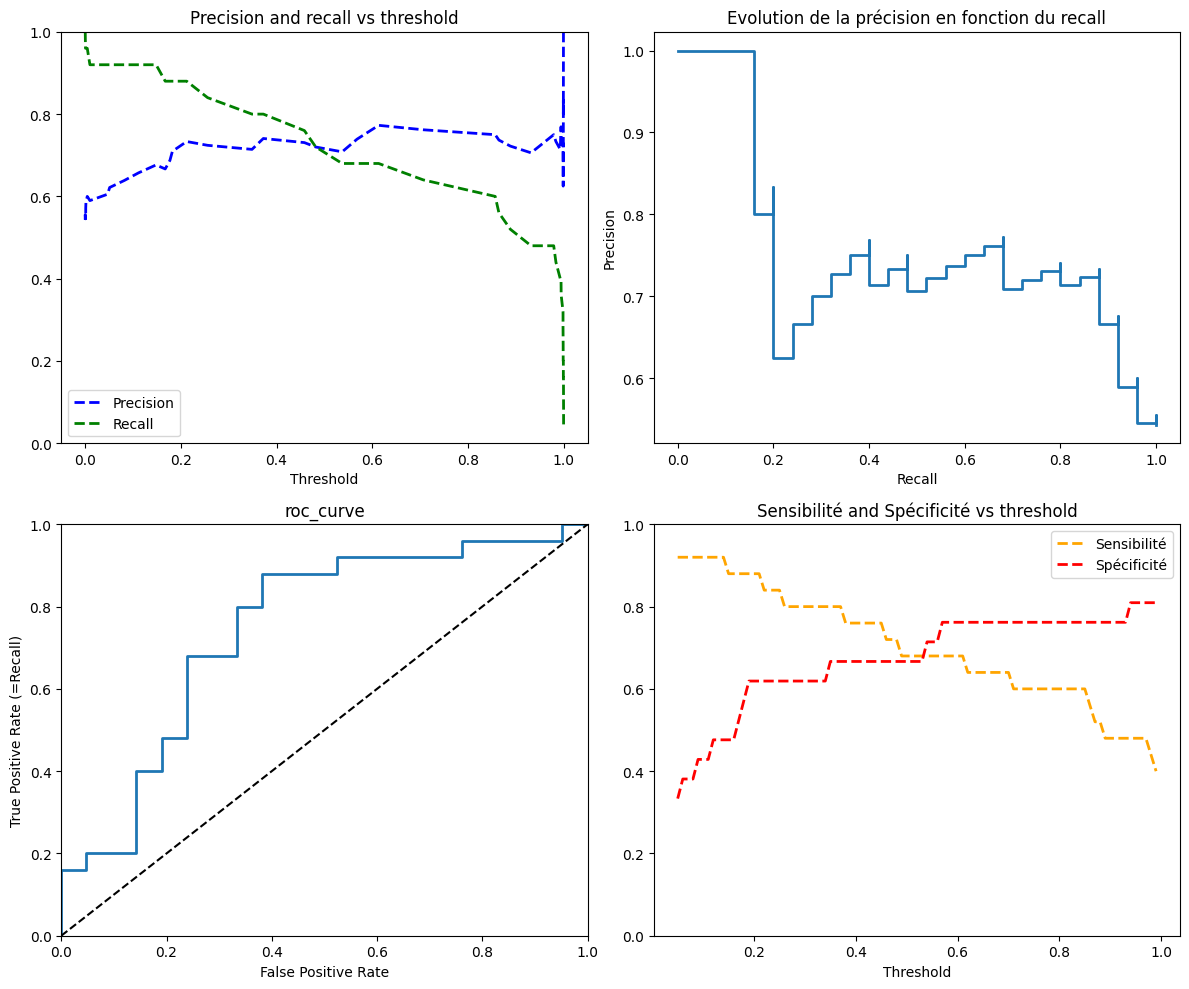

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [59]:
hi_2_opti_sensi = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_sensi)
bs_2_sensi = BayesSearchCV(hi_2_opti_sensi, param_hi, scoring=specificite, random_state=seed)
bs_2_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_sensi_2 = HistGradientBoostingClassifier(**dict(bs_2_sensi.best_params_),random_state=seed, categorical_features=list_type_variable_sensi)
tree_sensi_2.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_2 = tree_sensi_2.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_2, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi_2 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_2.loc['specificité','XGB_BL_sensi'])
dict_sensi_2 = from_model_to_bst_trhld(tree_sensi_2, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_2['best_threshold'])
print('Sensibilité :', dict_sensi_2['scores']['sensibilite'])
print('Spécificité :', dict_sensi_2['scores']['specificité'])

#### F1 :

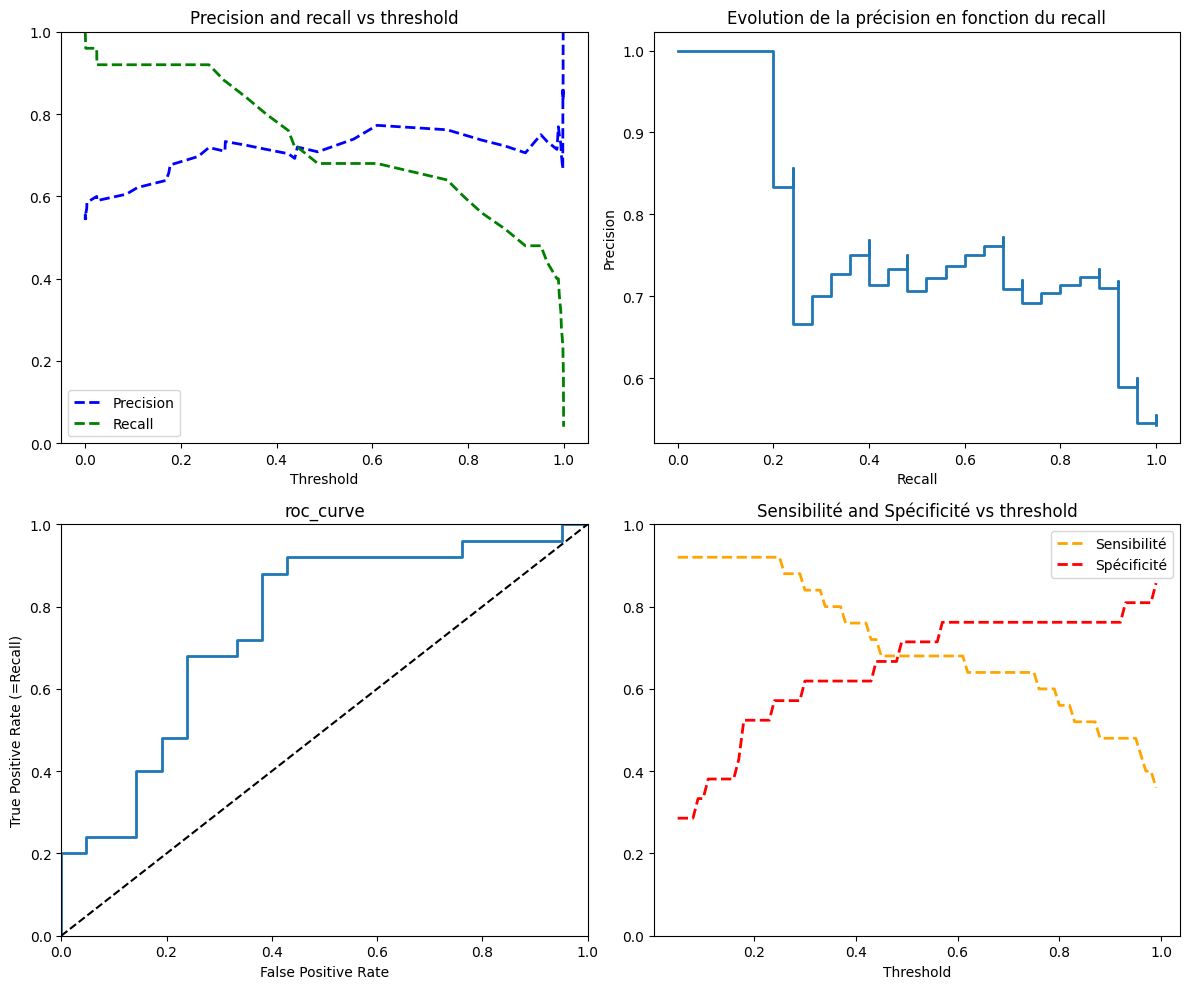

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.7142857142857143
_________________________________________________________
Best threshold : 0.93
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [60]:
hi_3_opti_sensi = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_sensi)
bs_3_sensi = BayesSearchCV(hi_3_opti_sensi, param_hi, scoring='f1', random_state=seed)
bs_3_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_sensi_3 = HistGradientBoostingClassifier(**dict(bs_3_sensi.best_params_),random_state=seed, categorical_features=list_type_variable_sensi)
tree_sensi_3.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_3 = tree_sensi_3.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_3, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi_3 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_3.loc['specificité','XGB_BL_sensi'])
dict_sensi_3 = from_model_to_bst_trhld(tree_sensi_3, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_3['best_threshold'])
print('Sensibilité :', dict_sensi_3['scores']['sensibilite'])
print('Spécificité :', dict_sensi_3['scores']['specificité'])

#### Custom :

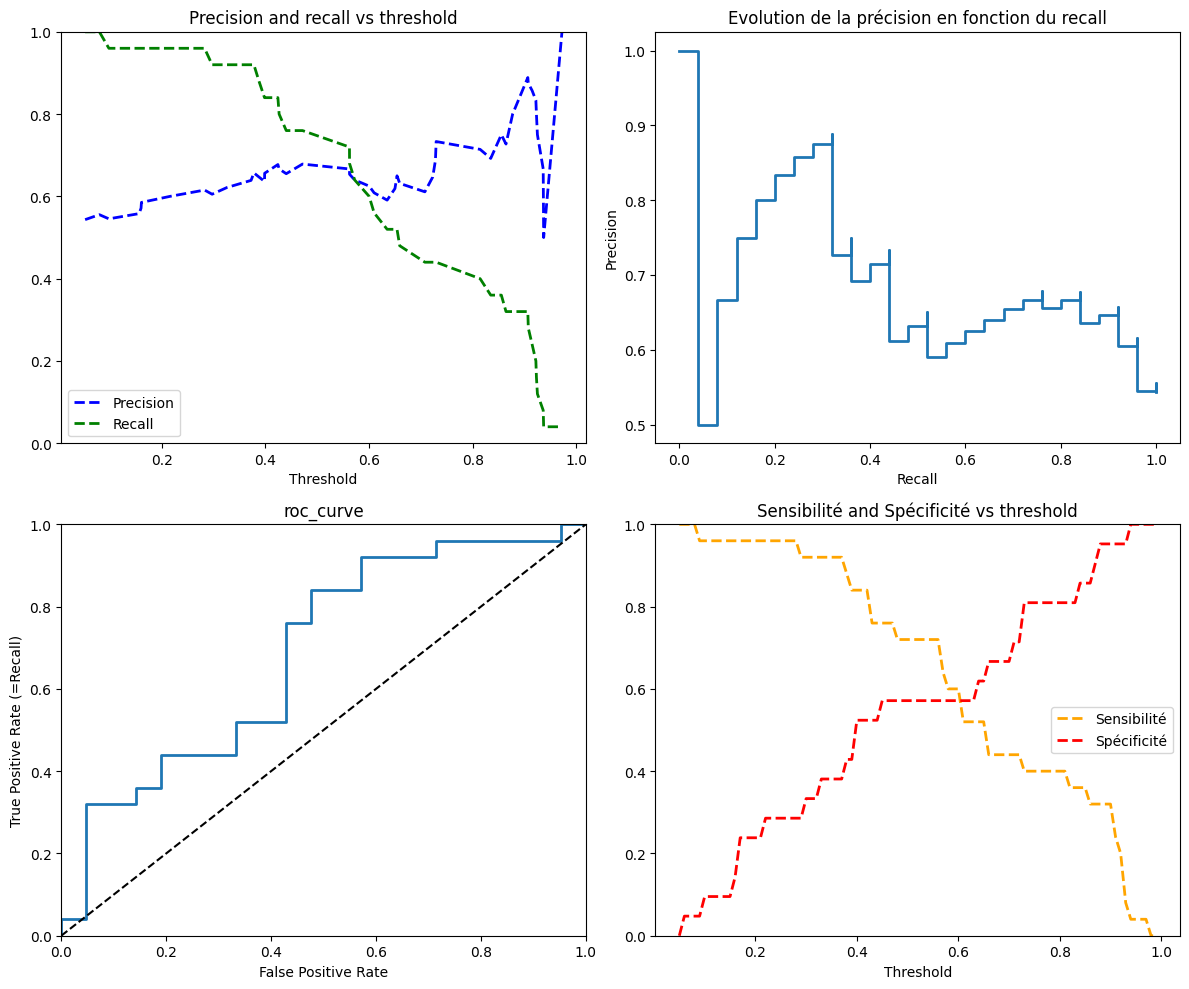

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.73
Sensibilité : 0.4
Spécificité : 0.8095238095238095


In [61]:
hi_4_opti_sensi = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_sensi)
bs4_sensi = BayesSearchCV(hi_4_opti_sensi, param_hi, scoring=scorer, random_state=seed)
bs4_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_sensi_4 = HistGradientBoostingClassifier(**dict(bs4_sensi.best_params_),random_state=seed, categorical_features=list_type_variable_sensi)
tree_sensi_4.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_4 = tree_sensi_4.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_4, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi_4 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_4.loc['specificité','XGB_BL_sensi'])
dict_sensi_4 = from_model_to_bst_trhld(tree_sensi_4, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_4['best_threshold'])
print('Sensibilité :', dict_sensi_4['scores']['sensibilite'])
print('Spécificité :', dict_sensi_4['scores']['specificité'])

#### Mix :

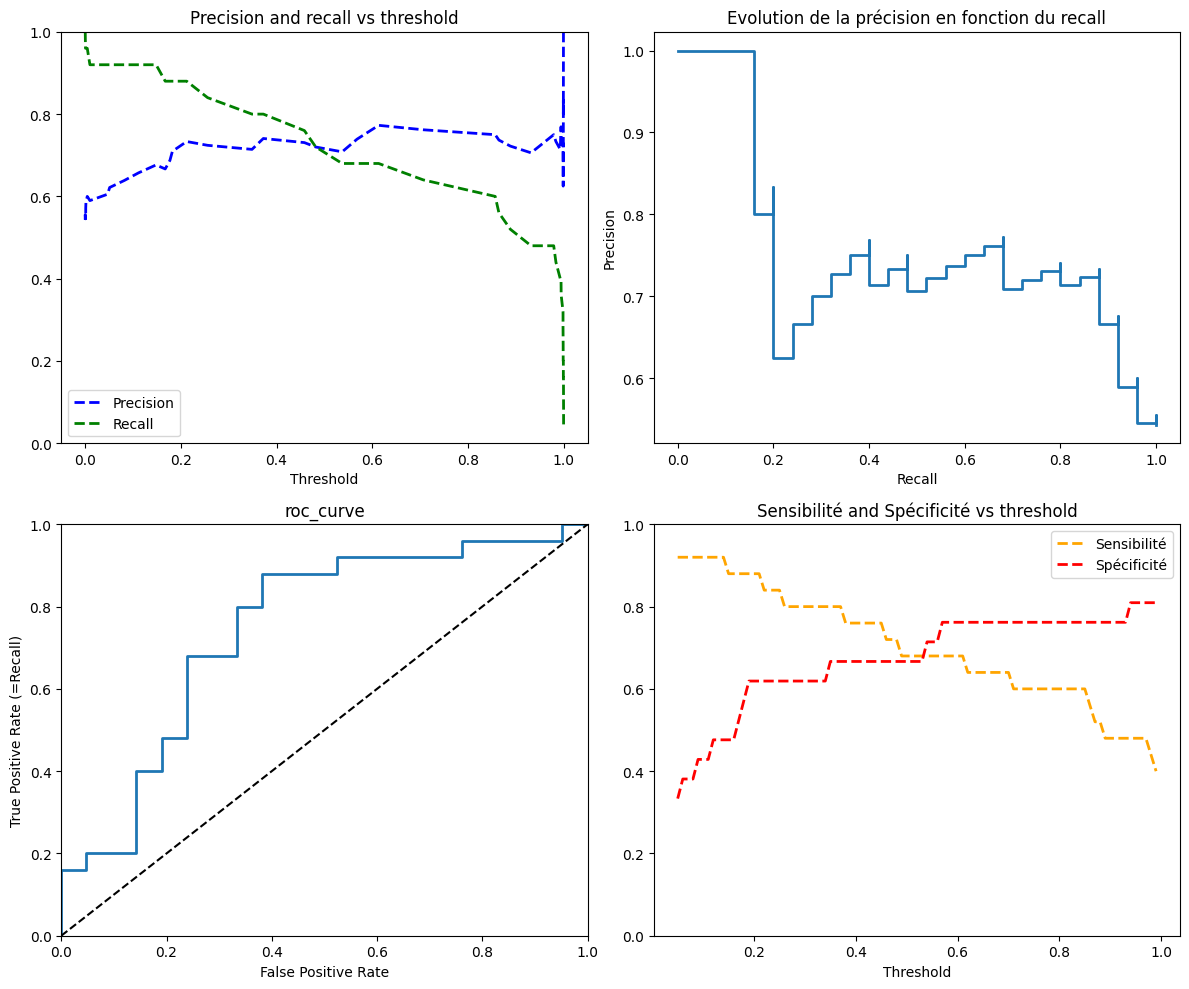

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [62]:
hi_5_opti_sensi = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_sensi)
bs5_sensi = BayesSearchCV(hi_5_opti_sensi, param_hi, scoring=mix_recall, random_state=seed)
bs5_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_sensi_5 = HistGradientBoostingClassifier(**dict(bs5_sensi.best_params_),random_state=seed, categorical_features=list_type_variable_sensi)
tree_sensi_5.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_5 = tree_sensi_5.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_5, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi_5 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_5.loc['specificité','XGB_BL_sensi'])
dict_sensi_5 = from_model_to_bst_trhld(tree_sensi_5, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_5['best_threshold'])
print('Sensibilité :', dict_sensi_5['scores']['sensibilite'])
print('Spécificité :', dict_sensi_5['scores']['specificité'])

#### average precision

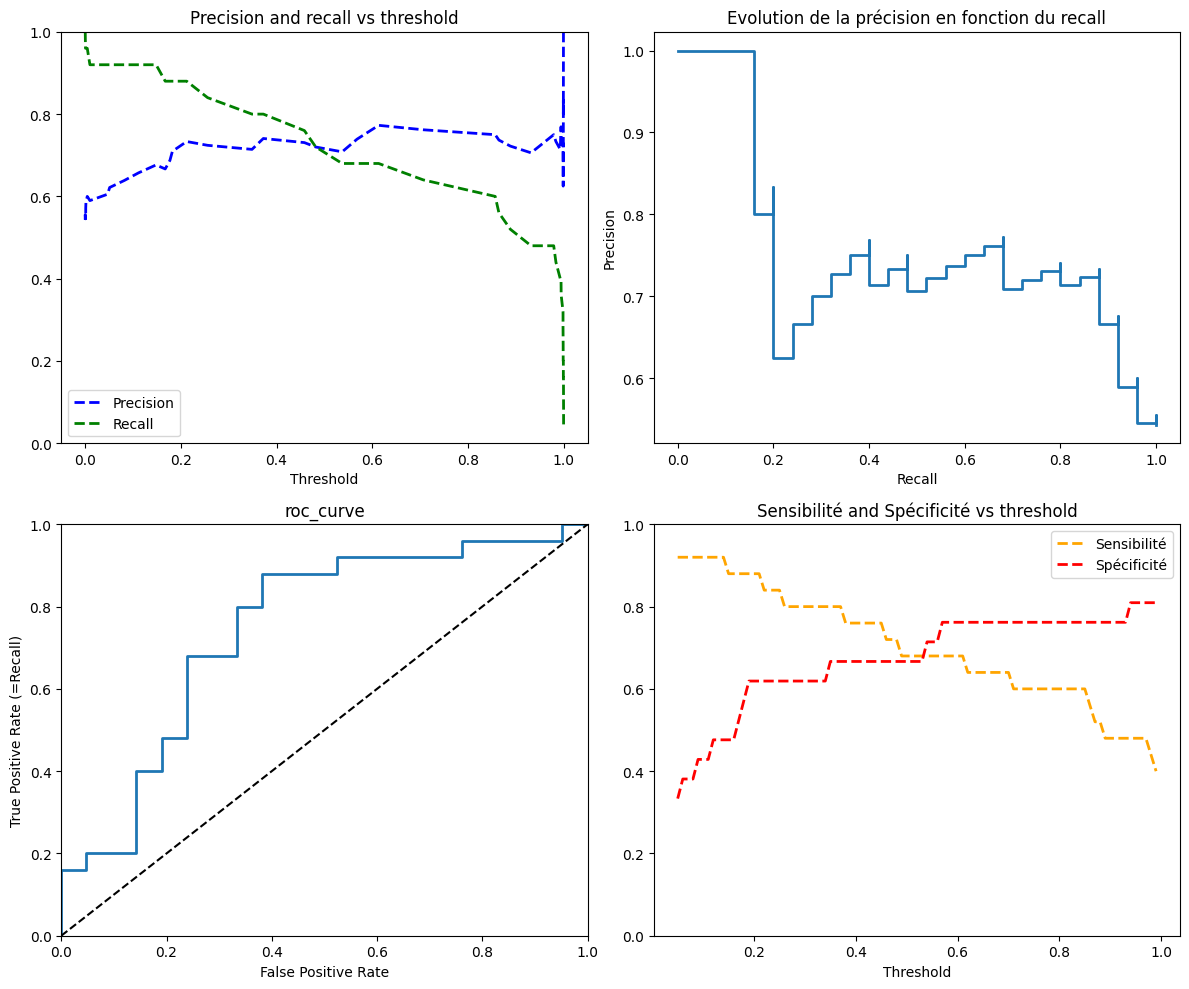

threshold = 0,5
Sensibilité :  0.76
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.9
Sensibilité : 0.6
Spécificité : 0.8095238095238095


In [63]:
hi_6_opti_sensi = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_sensi)
bs6_sensi = BayesSearchCV(hi_6_opti_sensi, param_hi, scoring='average_precision', random_state=seed)
bs6_sensi.fit(X_train.loc[:,liste_col_sensi], y_train)
tree_sensi_6 = HistGradientBoostingClassifier(**dict(bs6_sensi.best_params_),random_state=seed, categorical_features=list_type_variable_sensi)
tree_sensi_6.fit(X_train.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_6 = tree_sensi_6.predict(X_test.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_5, X_test.loc[:,liste_col_sensi], y_test)
resultat_sensi_6 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_6.loc['specificité','XGB_BL_sensi'])
dict_sensi_6 = from_model_to_bst_trhld(tree_sensi_6, X_test.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_6['best_threshold'])
print('Sensibilité :', dict_sensi_6['scores']['sensibilite'])
print('Spécificité :', dict_sensi_6['scores']['specificité'])

## ML speci

## Base line : 

In [64]:
list_type_variable_speci = []
for name, series in X_train.loc[:,liste_col_speci].items():
    if len(series.value_counts())<=2:
        list_type_variable_speci.append(True)
    else :
        list_type_variable_speci.append(False) 

In [65]:
# Init du modèle :
HI_baseline = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_speci)
# Préparation des datas :

# Entrainement :
baseline_HGB_cv = cross_validate(HI_baseline, X_train.loc[:,liste_col_speci], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(baseline_HGB_cv['test_sensi'].mean(), 2))
print('speci : ',round(baseline_HGB_cv['test_speci'].mean(),2))

sensi :  0.6
speci :  0.56


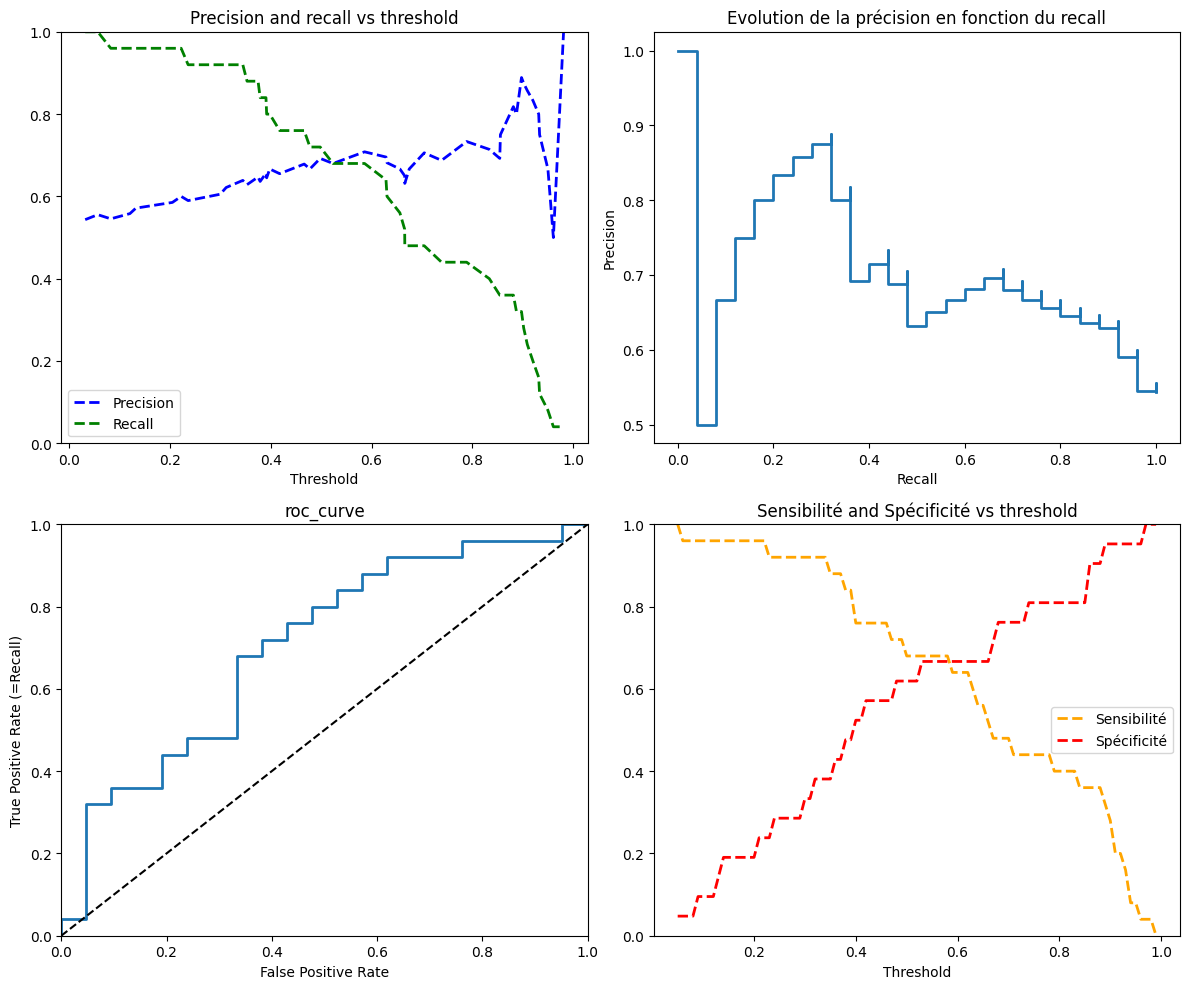

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.74
Sensibilité : 0.44
Spécificité : 0.8095238095238095


In [66]:
# Init du modèle :
HI_speci = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_speci)
# Préparation des datas :
HI_speci.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_sensi = HI_speci.predict(X_test.loc[:,liste_col_speci])
model_to_plot(HI_speci, X_test.loc[:,liste_col_speci], y_test)
resultat_bl1 = pd.DataFrame(pd.Series(scores(y_test, pred_bl1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl1.loc['specificité','XGB_BL_sensi'])
dict_bl_1 = from_model_to_bst_trhld(HI_speci, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_bl_1['best_threshold'])
print('Sensibilité :', dict_bl_1['scores']['sensibilite'])
print('Spécificité :', dict_bl_1['scores']['specificité'])

### Optimisation : 

#### Sensi :

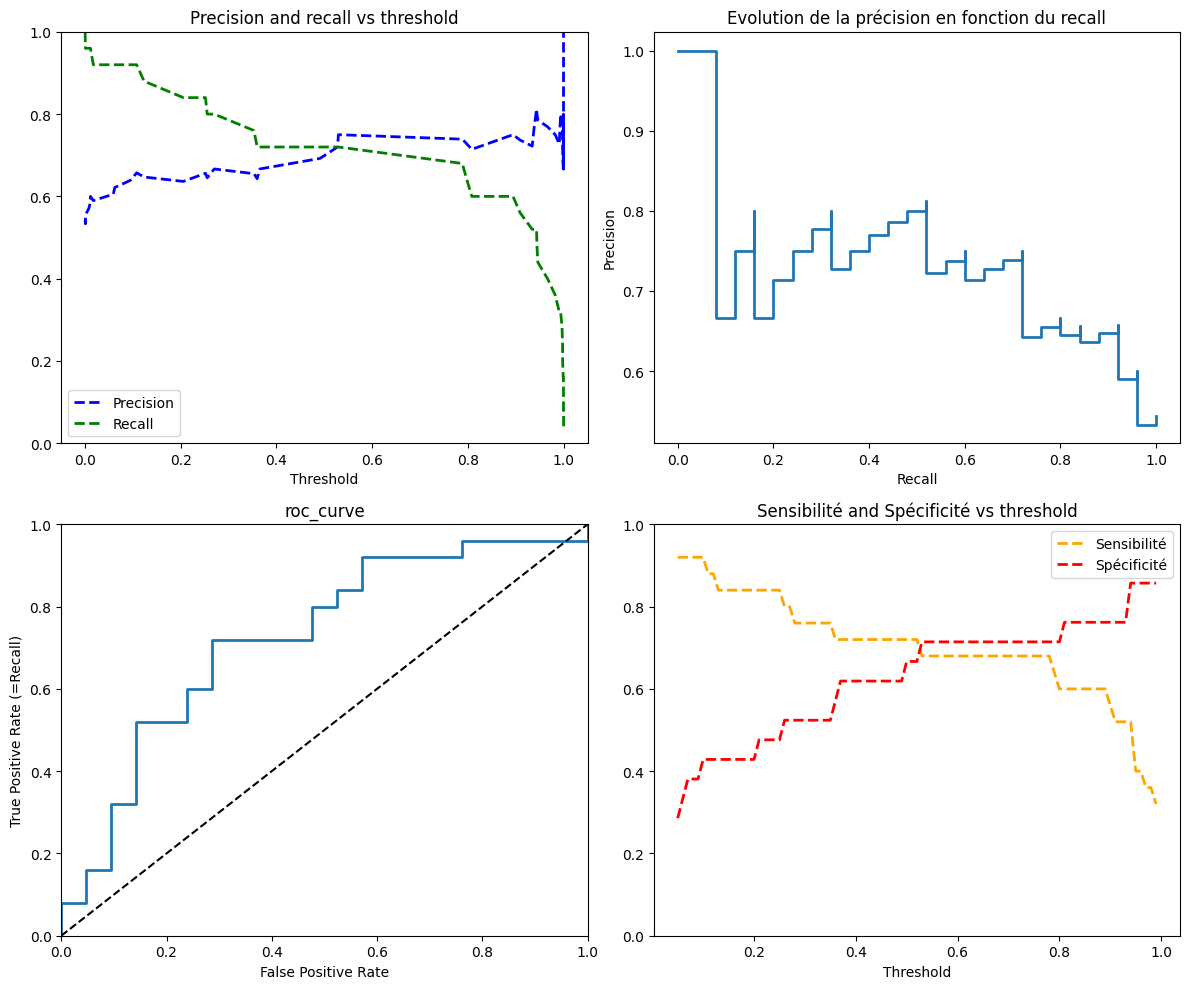

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.52
Spécificité : 0.8571428571428571


In [67]:
hi_1_opti_speci = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_speci)
bs_1_speci = BayesSearchCV(hi_1_opti_speci, param_hi, scoring=sensibilite, random_state=seed)
bs_1_speci.fit(X_train.loc[:,liste_col_speci], y_train)
tree_speci_1 = HistGradientBoostingClassifier(**dict(bs_1_speci.best_params_),random_state=seed, categorical_features=list_type_variable_speci)
tree_speci_1.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_1 = tree_speci_1.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_speci_1, X_test.loc[:,liste_col_speci], y_test)
resultat_sensi_1 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_1.loc['specificité','XGB_BL_sensi'])
dict_sensi_1 = from_model_to_bst_trhld(tree_speci_1, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_1['best_threshold'])
print('Sensibilité :', dict_sensi_1['scores']['sensibilite'])
print('Spécificité :', dict_sensi_1['scores']['specificité'])

#### Spéci :

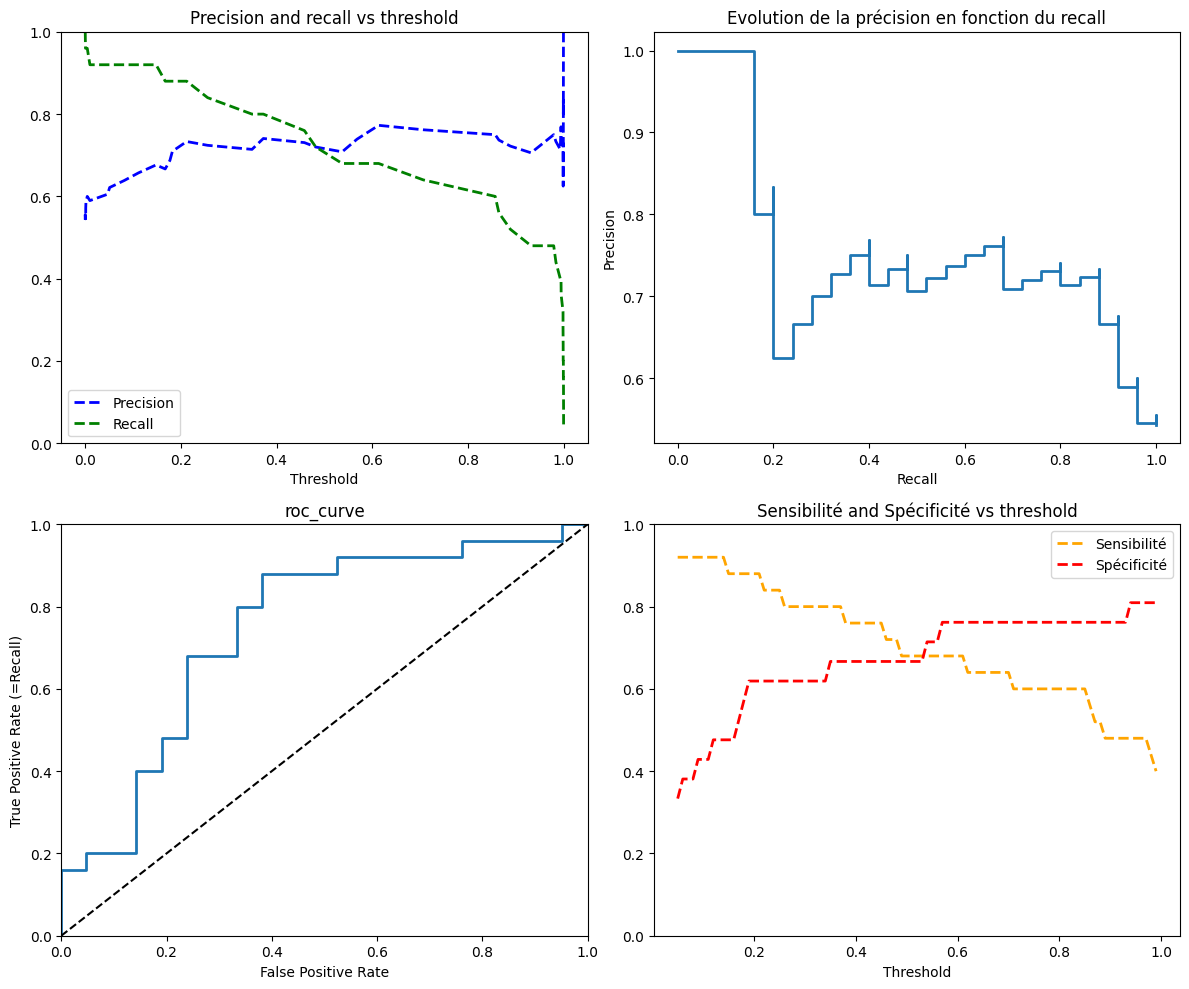

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [68]:
hi_2_opti_spe = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_speci)
bs_2_spe = BayesSearchCV(hi_2_opti_spe, param_hi, scoring=specificite, random_state=seed)
bs_2_spe.fit(X_train.loc[:,liste_col_speci], y_train)
tree_speci_2 = HistGradientBoostingClassifier(**dict(bs_2_spe.best_params_),random_state=seed, categorical_features=list_type_variable_speci)
tree_speci_2.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_2 = tree_speci_2.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_speci_2, X_test.loc[:,liste_col_speci], y_test)
resultat_sensi_2 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_2.loc['specificité','XGB_BL_sensi'])
dict_sensi_2 = from_model_to_bst_trhld(tree_speci_2, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_2['best_threshold'])
print('Sensibilité :', dict_sensi_2['scores']['sensibilite'])
print('Spécificité :', dict_sensi_2['scores']['specificité'])

#### F1 :

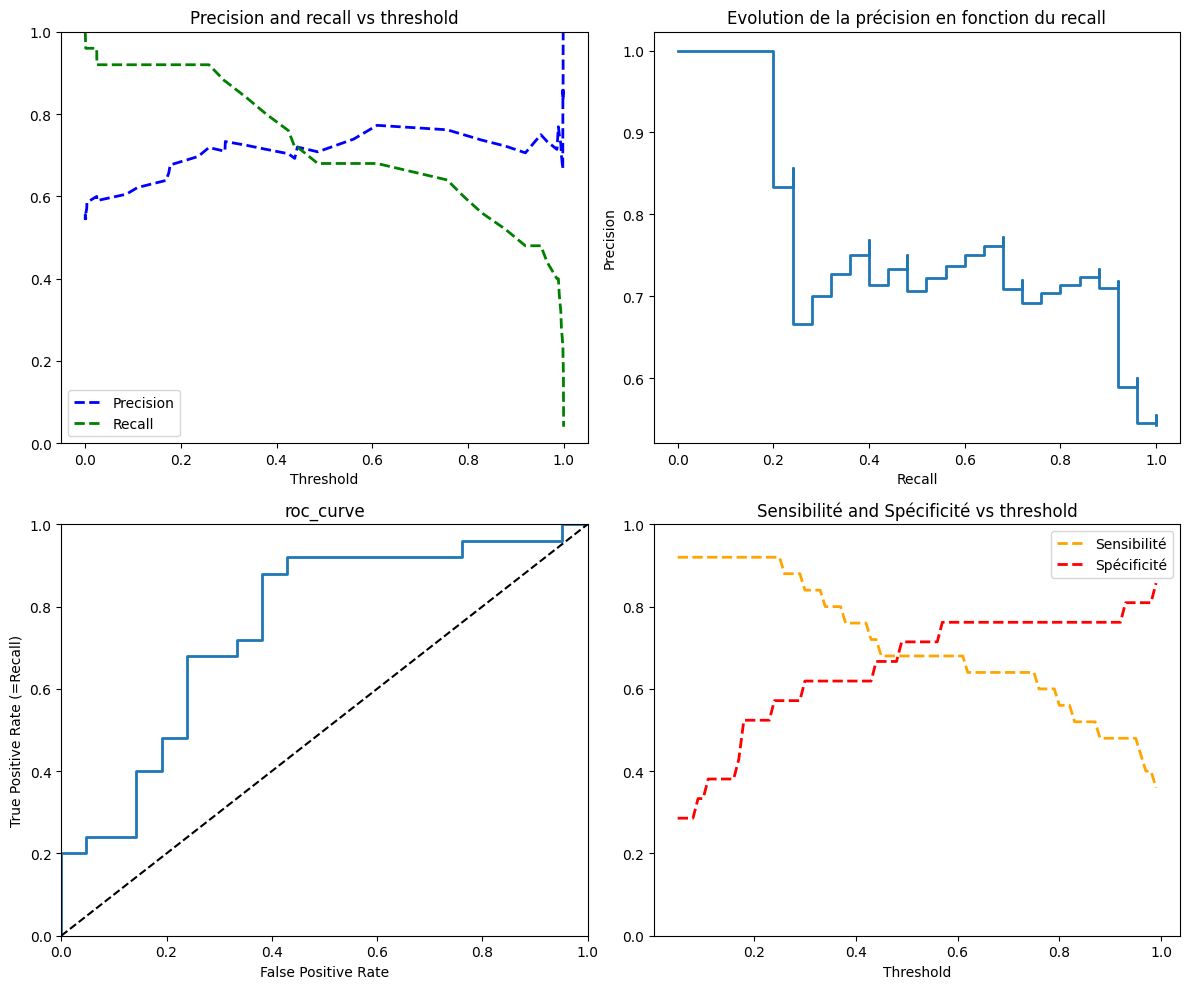

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.7142857142857143
_________________________________________________________
Best threshold : 0.93
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [69]:
hi_3_opti_spe = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_speci)
bs_3_spe = BayesSearchCV(hi_3_opti_spe, param_hi, scoring='f1', random_state=seed)
bs_3_spe.fit(X_train.loc[:,liste_col_speci], y_train)
tree_speci_3 = HistGradientBoostingClassifier(**dict(bs_3_spe.best_params_),random_state=seed, categorical_features=list_type_variable_speci)
tree_speci_3.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_3 = tree_speci_3.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_speci_3, X_test.loc[:,liste_col_speci], y_test)
resultat_sensi_3 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_3.loc['specificité','XGB_BL_sensi'])
dict_sensi_3 = from_model_to_bst_trhld(tree_speci_3, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_3['best_threshold'])
print('Sensibilité :', dict_sensi_3['scores']['sensibilite'])
print('Spécificité :', dict_sensi_3['scores']['specificité'])

#### Custom :

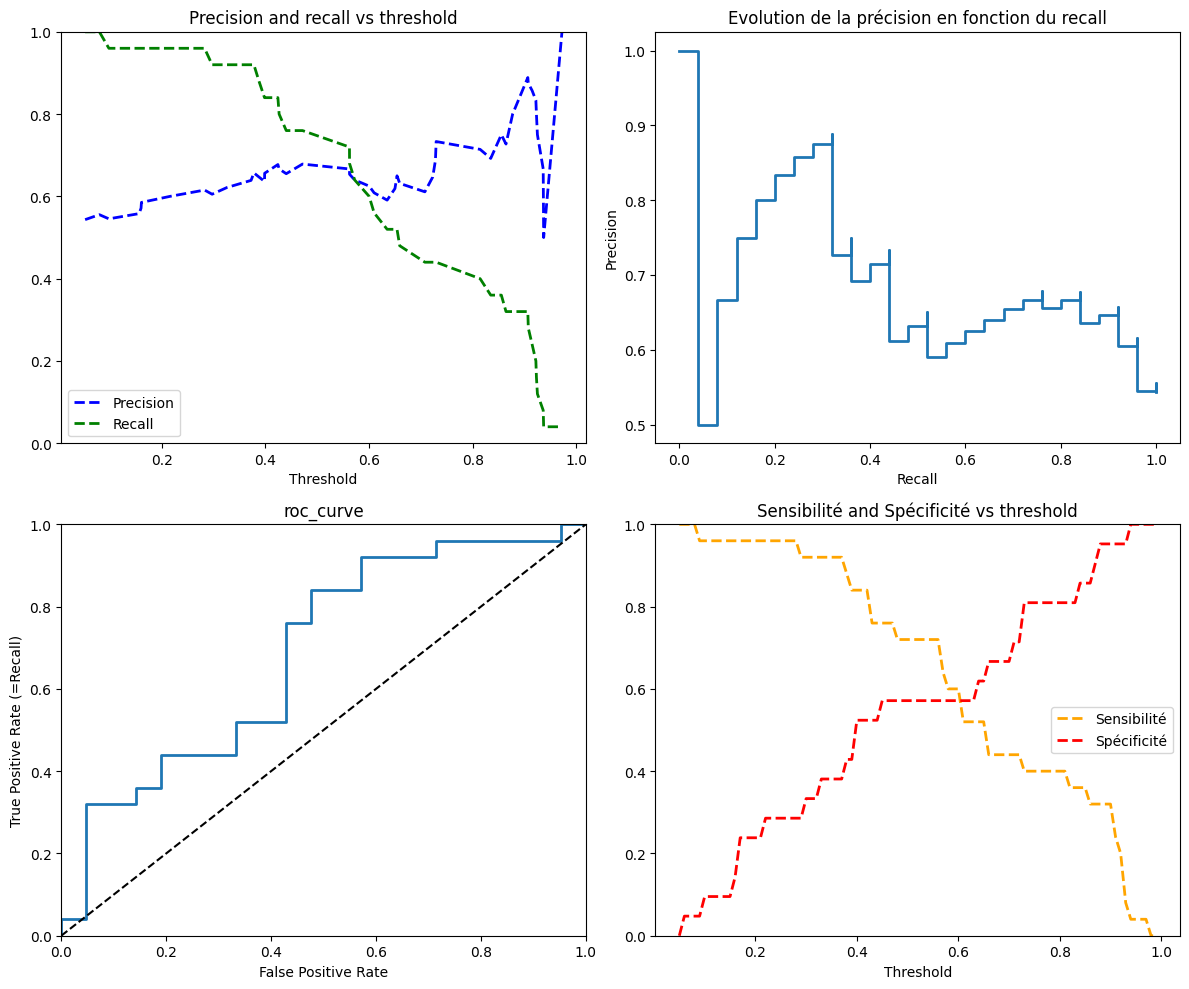

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.73
Sensibilité : 0.4
Spécificité : 0.8095238095238095


In [70]:
hi_4_opti_spe = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_speci)
bs4_spe = BayesSearchCV(hi_4_opti_spe, param_hi, scoring=scorer, random_state=seed)
bs4_spe.fit(X_train.loc[:,liste_col_speci], y_train)
tree_speci_4 = HistGradientBoostingClassifier(**dict(bs4_spe.best_params_),random_state=seed, categorical_features=list_type_variable_speci)
tree_speci_4.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_4 = tree_speci_4.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_speci_4, X_test.loc[:,liste_col_speci], y_test)
resultat_sensi_4 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_4.loc['specificité','XGB_BL_sensi'])
dict_sensi_4 = from_model_to_bst_trhld(tree_speci_4, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_4['best_threshold'])
print('Sensibilité :', dict_sensi_4['scores']['sensibilite'])
print('Spécificité :', dict_sensi_4['scores']['specificité'])

#### Mix :

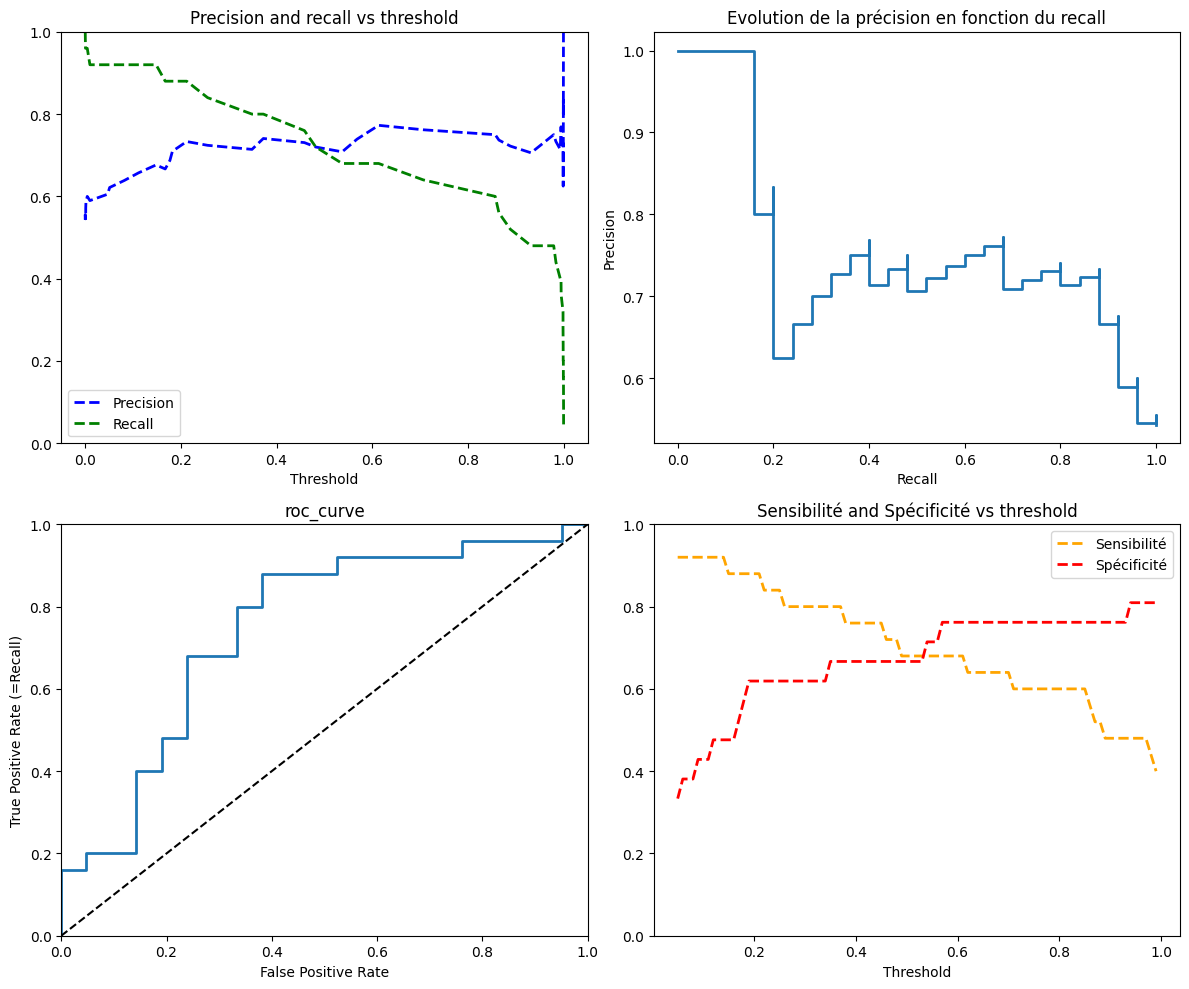

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [71]:
hi_5_opti_spe = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_speci)
bs5_spe = BayesSearchCV(hi_5_opti_spe, param_hi, scoring=mix_recall, random_state=seed)
bs5_spe.fit(X_train.loc[:,liste_col_speci], y_train)
tree_speci_5 = HistGradientBoostingClassifier(**dict(bs5_spe.best_params_),random_state=seed, categorical_features=list_type_variable_speci)
tree_speci_5.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_5 = tree_speci_5.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_speci_5, X_test.loc[:,liste_col_speci], y_test)
resultat_sensi_5 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_5.loc['specificité','XGB_BL_sensi'])
dict_sensi_5 = from_model_to_bst_trhld(tree_speci_5, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_5['best_threshold'])
print('Sensibilité :', dict_sensi_5['scores']['sensibilite'])
print('Spécificité :', dict_sensi_5['scores']['specificité'])

#### average precision

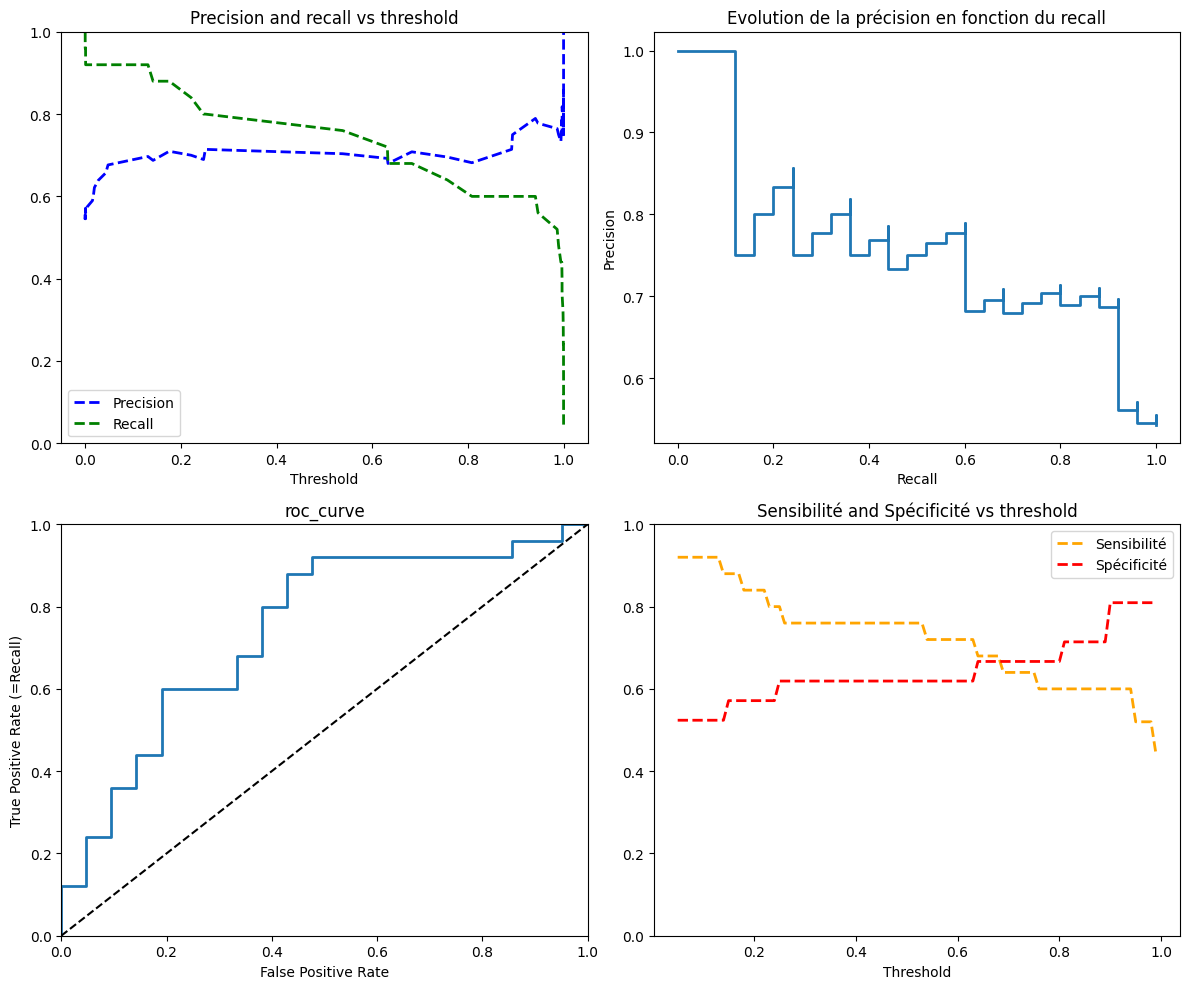

threshold = 0,5
Sensibilité :  0.76
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.9
Sensibilité : 0.6
Spécificité : 0.8095238095238095


In [72]:
hi_6_opti_spe = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_speci)
bs6_spe = BayesSearchCV(hi_6_opti_spe, param_hi, scoring='average_precision', random_state=seed)
bs6_spe.fit(X_train.loc[:,liste_col_speci], y_train)
tree_speci_6 = HistGradientBoostingClassifier(**dict(bs6_spe.best_params_),random_state=seed, categorical_features=list_type_variable_speci)
tree_speci_6.fit(X_train.loc[:,liste_col_speci], y_train)
# Results :
pred_speci_6 = tree_speci_6.predict(X_test.loc[:,liste_col_speci])
model_to_plot(tree_speci_6, X_test.loc[:,liste_col_speci], y_test)
resultat_sensi_6 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_6.loc['specificité','XGB_BL_sensi'])
dict_sensi_6 = from_model_to_bst_trhld(tree_speci_6, X_test.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_6['best_threshold'])
print('Sensibilité :', dict_sensi_6['scores']['sensibilite'])
print('Spécificité :', dict_sensi_6['scores']['specificité'])

## ML mixte : 

### Base line : 

In [73]:
list_type_variable_mixte = []
for name, series in X_train.loc[:,liste_col_mixte].items():
    if len(series.value_counts())<=2:
        list_type_variable_mixte.append(True)
    else :
        list_type_variable_mixte.append(False) 

In [74]:
# Init du modèle :
HI_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_mixte)
# Préparation des datas :

# Entrainement :
mixte_HGB_cv = cross_validate(HI_mixte, X_train.loc[:,liste_col_mixte], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(mixte_HGB_cv['test_sensi'].mean(), 2))
print('speci : ',round(mixte_HGB_cv['test_speci'].mean(),2))

sensi :  0.6
speci :  0.56


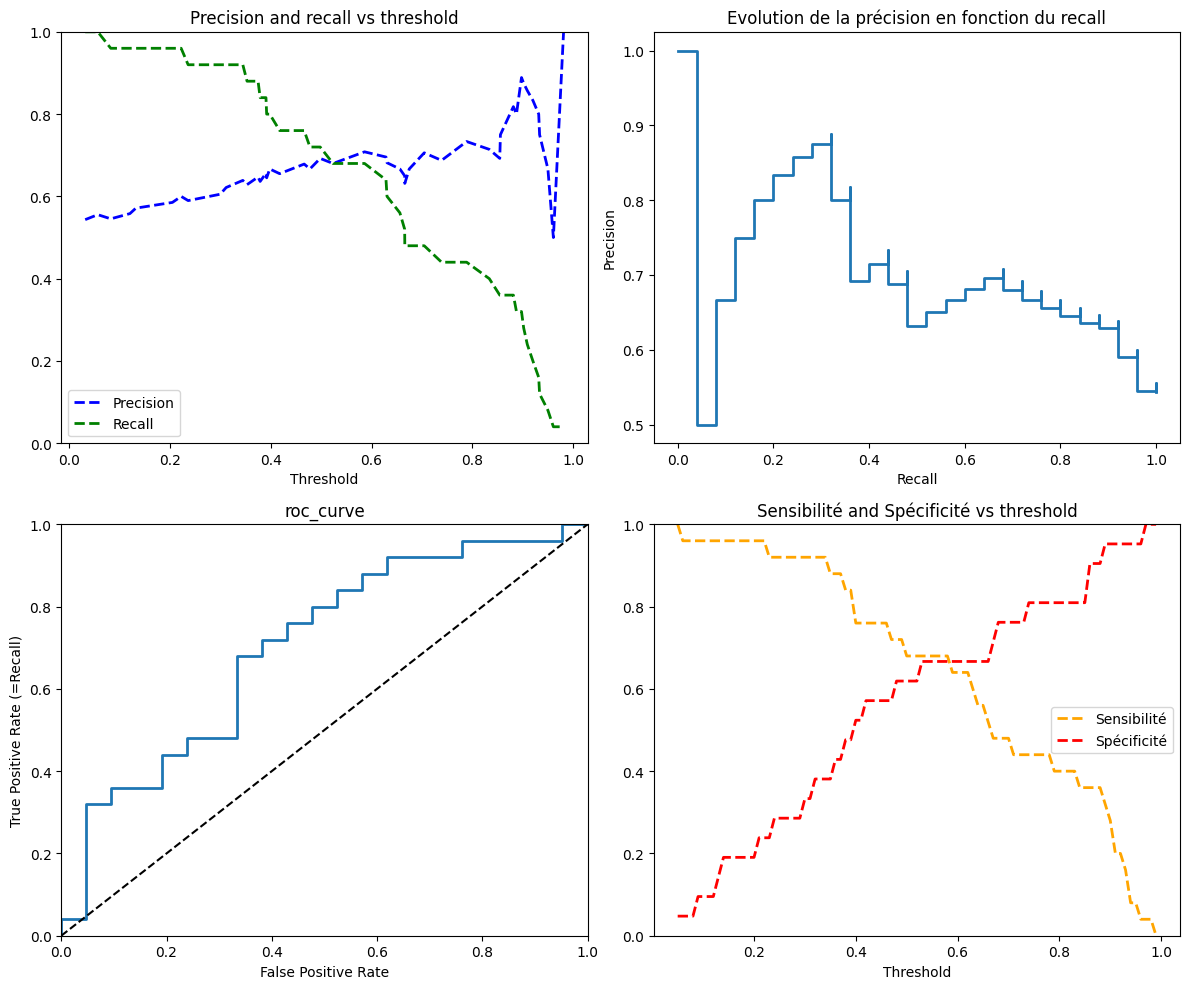

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.74
Sensibilité : 0.44
Spécificité : 0.8095238095238095


In [75]:
# Init du modèle :
HI_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_mixte)
# Préparation des datas :
HI_mixte.fit(X_train.loc[:,liste_col_mixte], y_train)
# Results :
pred_bl_sensi = HI_mixte.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(HI_mixte, X_test.loc[:,liste_col_mixte], y_test)
resultat_sensi = pd.DataFrame(pd.Series(scores(y_test, pred_bl_sensi)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi.loc['specificité','XGB_BL_sensi'])
dict_sensi = from_model_to_bst_trhld(HI_mixte, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi['best_threshold'])
print('Sensibilité :', dict_sensi['scores']['sensibilite'])
print('Spécificité :', dict_sensi['scores']['specificité'])

### Optimisation : 

##### Sensi :

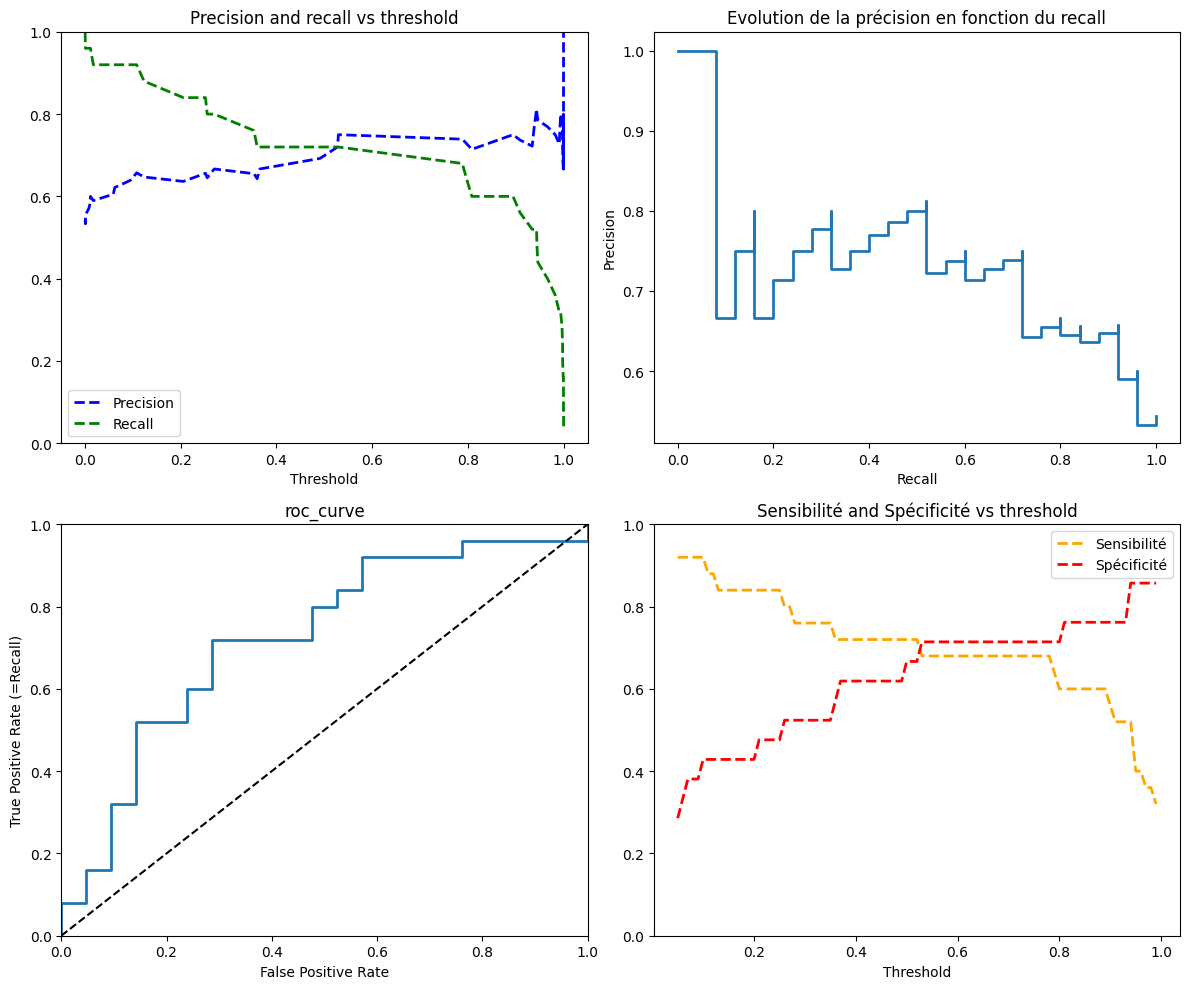

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.52
Spécificité : 0.8571428571428571


In [76]:
hi_1_opti_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_mixte)
bs_1_mixte = BayesSearchCV(hi_1_opti_mixte, param_hi, scoring=sensibilite, random_state=seed)
bs_1_mixte.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_mixte_1 = HistGradientBoostingClassifier(**dict(bs_1_mixte.best_params_),random_state=seed, categorical_features=list_type_variable_mixte)
tree_mixte_1.fit(X_train.loc[:,liste_col_mixte], y_train)
pred_bl_mixte1 = tree_mixte_1.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_1, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte1 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_mixte1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte1.loc['specificité','XGB_BL_sensi'])
dict_mixte1 = from_model_to_bst_trhld(tree_mixte_1, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte1['best_threshold'])
print('Sensibilité :', dict_mixte1['scores']['sensibilite'])
print('Spécificité :', dict_mixte1['scores']['specificité'])

##### Spéci :

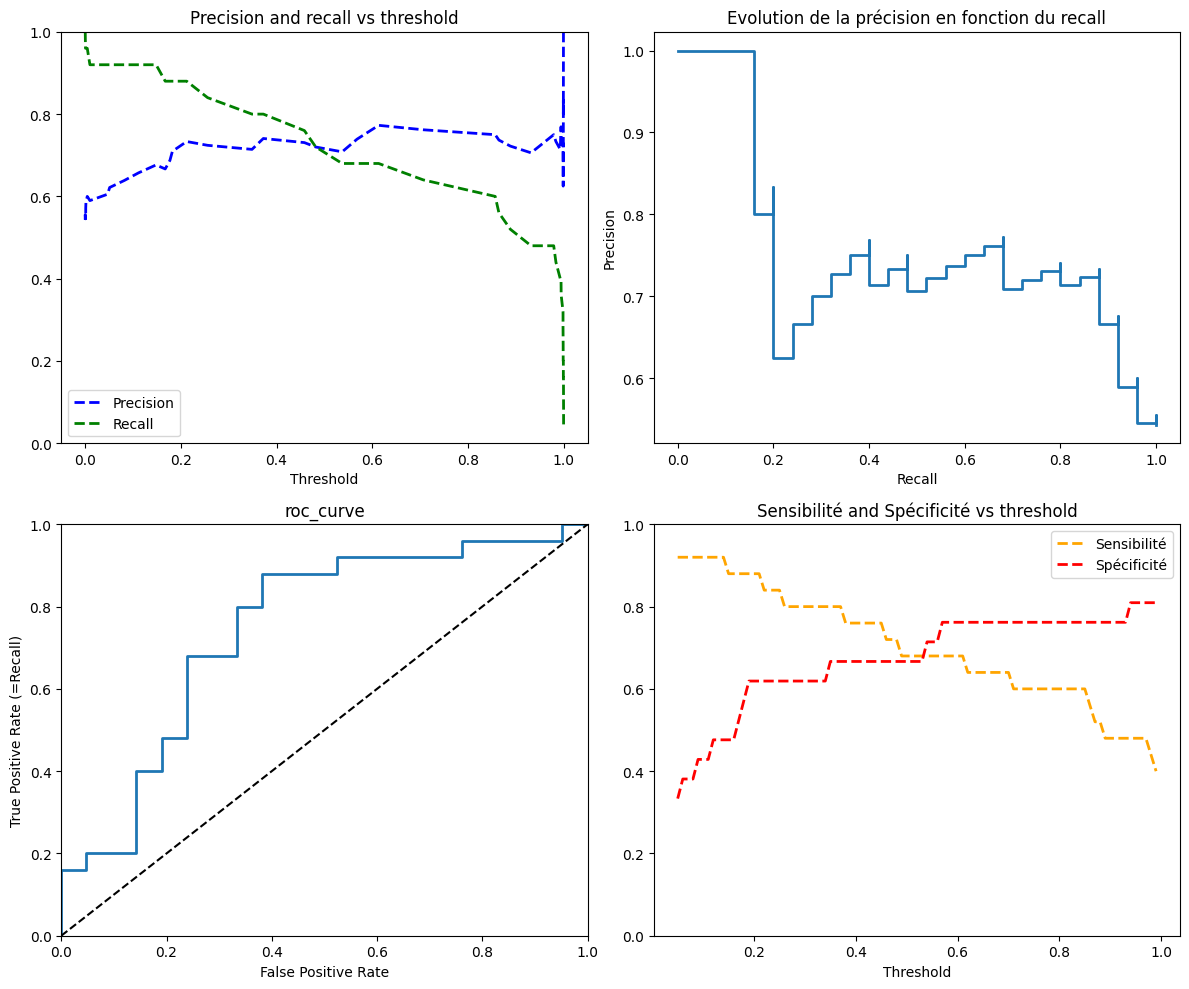

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [77]:
hi_2_opti_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_mixte)
bs_2_mixte = BayesSearchCV(hi_2_opti_mixte, param_hi, scoring=specificite, random_state=seed)
bs_2_mixte.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_mixte_2 = HistGradientBoostingClassifier(**dict(bs_2_mixte.best_params_),random_state=seed, categorical_features=list_type_variable_mixte)
tree_mixte_2.fit(X_train.loc[:,liste_col_mixte], y_train)
pred_bl_mixte2 = tree_mixte_2.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_2, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_2 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_mixte2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_2.loc['specificité','XGB_BL_sensi'])
dict_mixte_2 = from_model_to_bst_trhld(tree_mixte_2, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_2['best_threshold'])
print('Sensibilité :', dict_mixte_2['scores']['sensibilite'])
print('Spécificité :', dict_mixte_2['scores']['specificité'])

##### F1 :

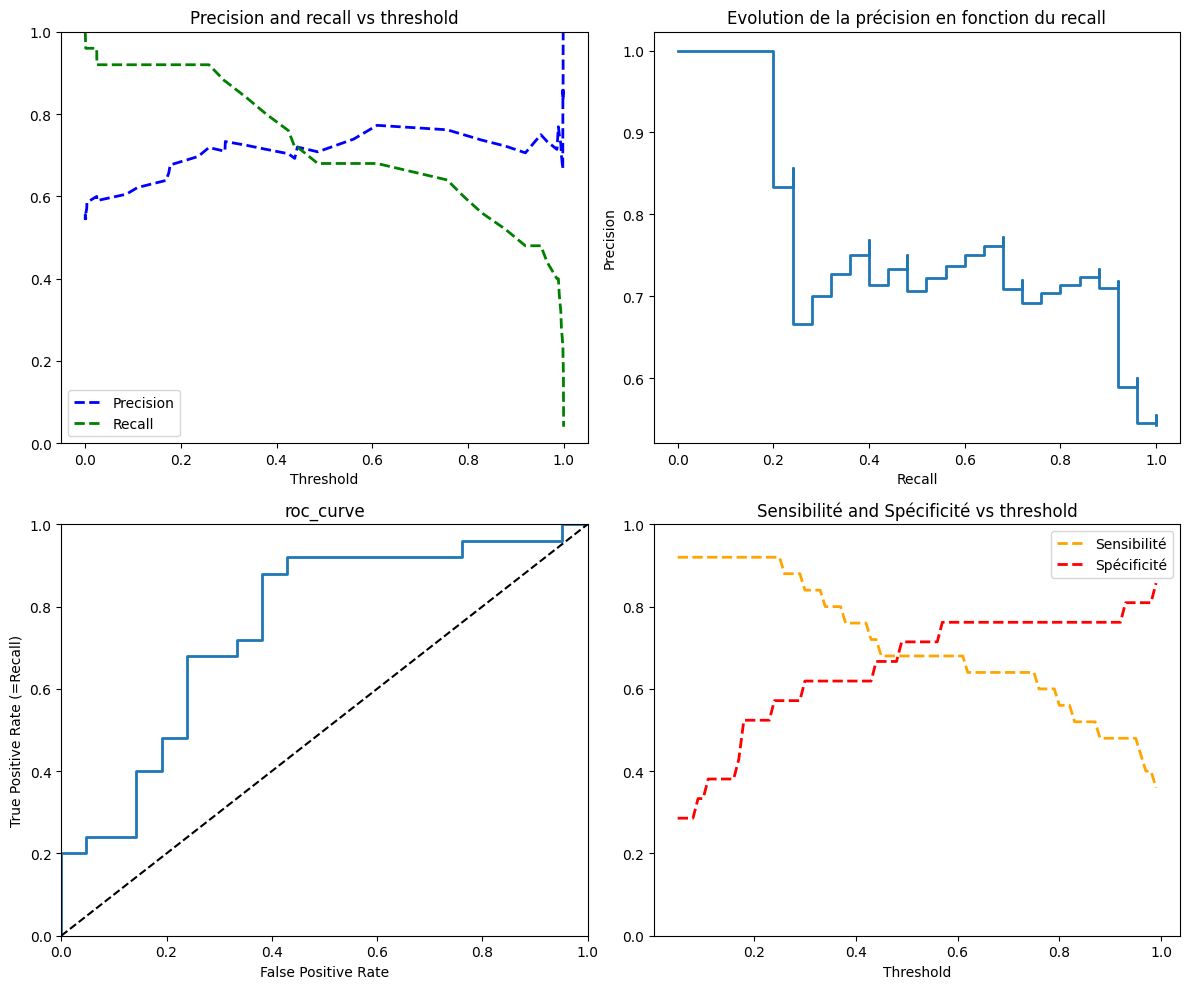

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.7142857142857143
_________________________________________________________
Best threshold : 0.93
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [79]:
hi_3_opti_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_mixte)
bs_3_mixte = BayesSearchCV(hi_3_opti_mixte, param_hi, scoring='f1', random_state=seed)
bs_3_mixte.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_mixte_3 = HistGradientBoostingClassifier(**dict(bs_3_mixte.best_params_),random_state=seed, categorical_features=list_type_variable_mixte)
tree_mixte_3.fit(X_train.loc[:,liste_col_mixte], y_train)
pred_bl_mixte_3 = tree_mixte_3.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_3, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_3 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_mixte_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_3.loc['specificité','XGB_BL_sensi'])
dict_mixte_3 = from_model_to_bst_trhld(tree_mixte_3, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_3['best_threshold'])
print('Sensibilité :', dict_mixte_3['scores']['sensibilite'])
print('Spécificité :', dict_mixte_3['scores']['specificité'])

##### Custom :

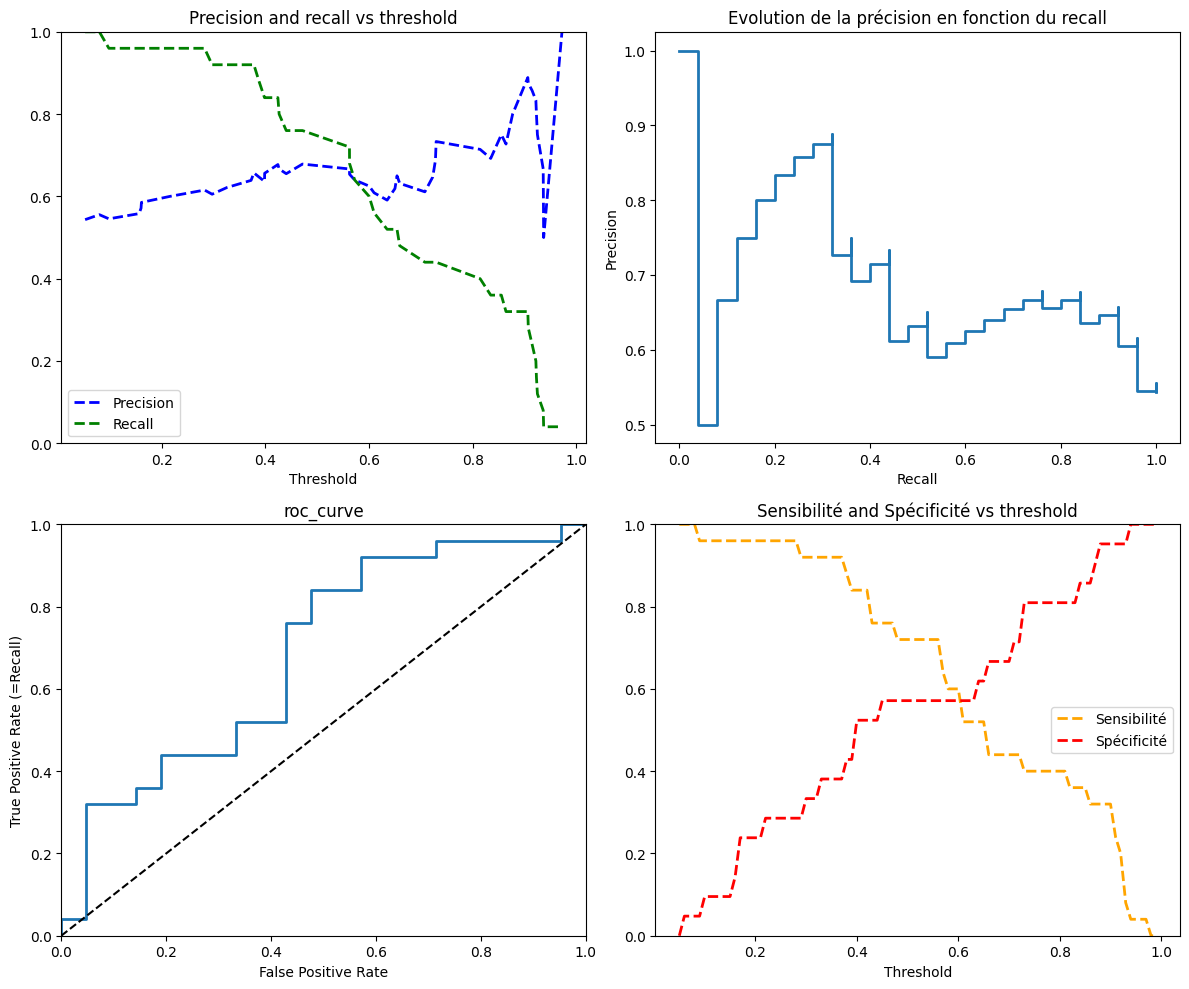

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.73
Sensibilité : 0.4
Spécificité : 0.8095238095238095


In [80]:
hi_4_opti_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_mixte)
bs4_mixte = BayesSearchCV(hi_4_opti_mixte, param_hi, scoring=scorer, random_state=seed)
bs4_mixte.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_mixte_4 = HistGradientBoostingClassifier(**dict(bs4_mixte.best_params_),random_state=seed, categorical_features=list_type_variable_mixte)
tree_mixte_4.fit(X_train.loc[:,liste_col_mixte], y_train)
pred_bl_mixte_4 = tree_mixte_4.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_4, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_4 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_mixte_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_4.loc['specificité','XGB_BL_sensi'])
dict_mixte_4 = from_model_to_bst_trhld(tree_mixte_4, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_4['best_threshold'])
print('Sensibilité :', dict_mixte_4['scores']['sensibilite'])
print('Spécificité :', dict_mixte_4['scores']['specificité'])

##### Mix :

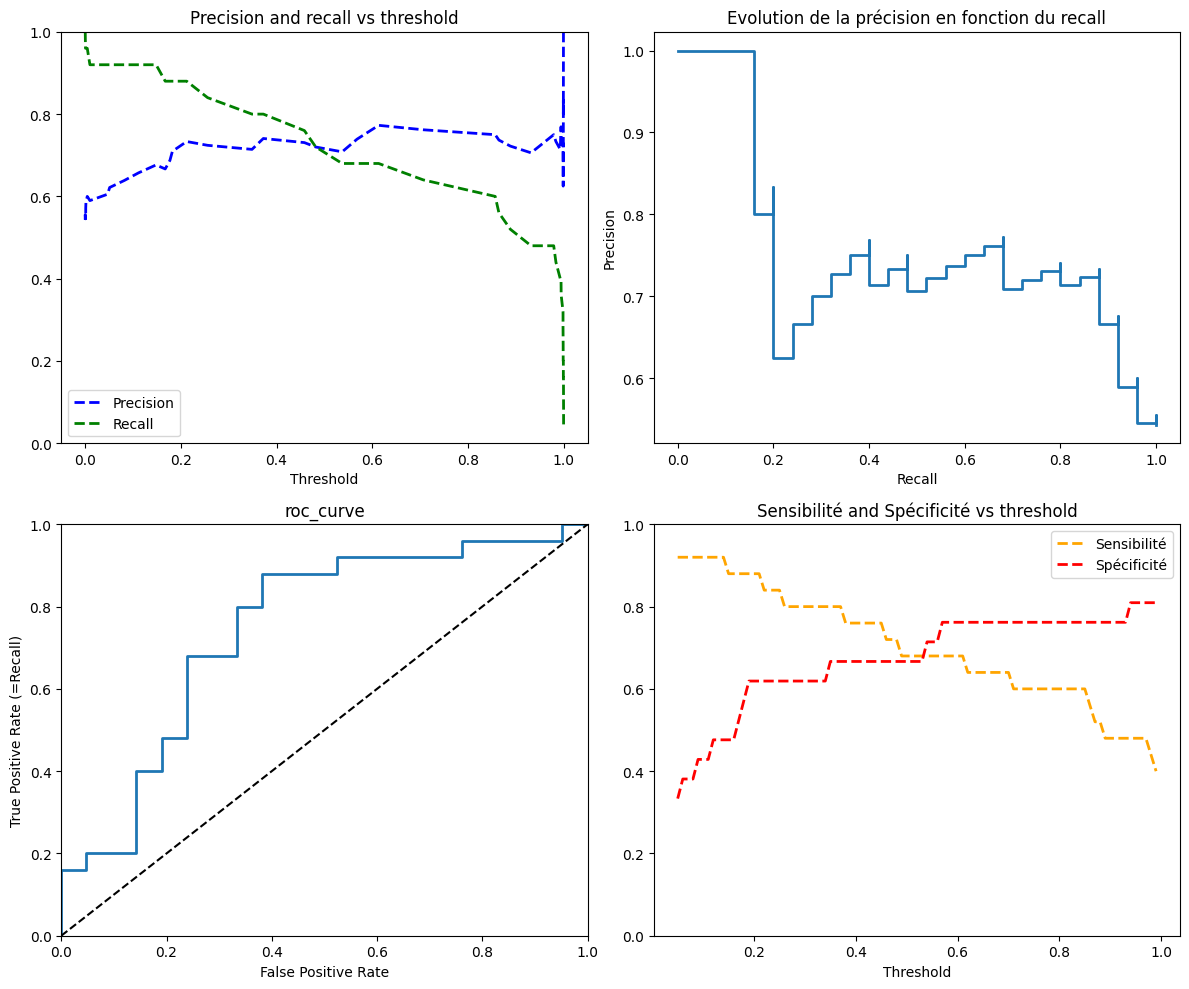

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.94
Sensibilité : 0.48
Spécificité : 0.8095238095238095


In [81]:
hi_5_opti_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_mixte)
bs5_mixte = BayesSearchCV(hi_5_opti_mixte, param_hi, scoring=mix_recall, random_state=seed)
bs5_mixte.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_mixte_5 = HistGradientBoostingClassifier(**dict(bs5_mixte.best_params_),random_state=seed, categorical_features=list_type_variable_mixte)
tree_mixte_5.fit(X_train.loc[:,liste_col_mixte], y_train)
pred_bl_mixte_5 = tree_mixte_5.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_5, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_5 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_mixte_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_5.loc['specificité','XGB_BL_sensi'])
dict_mixte_5 = from_model_to_bst_trhld(tree_mixte_5, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_5['best_threshold'])
print('Sensibilité :', dict_mixte_5['scores']['sensibilite'])
print('Spécificité :', dict_mixte_5['scores']['specificité'])

##### average precision

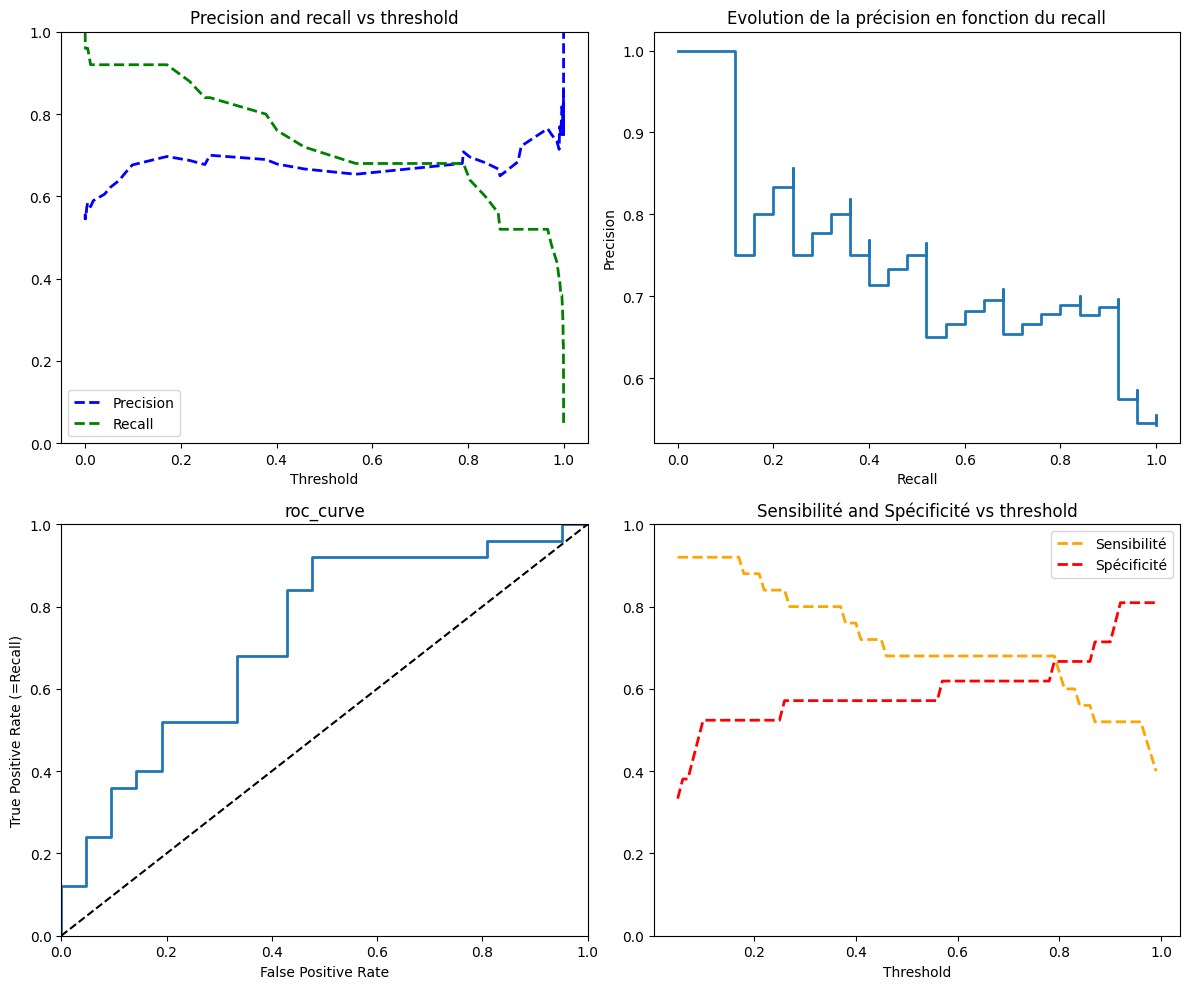

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.5714285714285714
_________________________________________________________
Best threshold : 0.92
Sensibilité : 0.52
Spécificité : 0.8095238095238095


In [82]:
hi_6_opti_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable_mixte)
bs6_mixte = BayesSearchCV(hi_6_opti_mixte, param_hi, scoring='average_precision', random_state=seed)
bs6_mixte.fit(X_train.loc[:,liste_col_mixte], y_train)
tree_mixte_6 = HistGradientBoostingClassifier(**dict(bs6_mixte.best_params_),random_state=seed, categorical_features=list_type_variable_mixte)
tree_mixte_6.fit(X_train.loc[:,liste_col_mixte], y_train)
pred_bl_mixte_6 = tree_mixte_6.predict(X_test.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_6, X_test.loc[:,liste_col_mixte], y_test)
resultat_mixte_6 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_mixte_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_6.loc['specificité','XGB_BL_sensi'])
dict_mixte_6 = from_model_to_bst_trhld(tree_mixte_6, X_test.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_6['best_threshold'])
print('Sensibilité :', dict_mixte_6['scores']['sensibilite'])
print('Spécificité :', dict_mixte_6['scores']['specificité'])

## ML speci + mixte : 

### Base line : 

In [99]:
list_type_variable = []
for name, series in X_train.loc[:,liste_col_speci+liste_col_mixte].items():
    if len(series.value_counts())<=2:
        list_type_variable.append(True)
    else :
        list_type_variable.append(False) 
# Print columns after dropping correlated columns
print("Columns in X_train_ after dropping correlated columns:", list(X_train_.columns))
print("Columns in X_test_ after dropping correlated columns:", list(X_test_.columns))

Columns in X_train_ after dropping correlated columns: ['age', 'imc', 'g', 'atcd.endo', 'atcd.chir.oma', 'atcd.fibrome', 'atcd.pma', 'atcd.fiv', 'desir.G', 'atcd.sma.douleur', 'atcd.hospit.douleur', 'atcd.absenteisme', 'ttt.op', 'ttt.p', 'ttt.ains', 'ttt.p1', 'ttt.p2', 'ttt.p3', 'sf.dsm.type', 'sf.dsm.eva', 'sf.dpc', 'sf.dsp.eva', 'sf.dig.diarrhee', 'sf.dig.constip', 'sf.dig.rectorragie', 'sf.uro', 'sf.scap', 'sf.ombilic', 'effet.hormone', 'ef.hormone.dsp', 'ef.hormone.dpc', 'effet.hormone.dig', 'tv.douloureux', 'tv.douleur.lusd', 'tv.douleur.lusg', 'tv.douleur.torus', 'tv.nodule.lusd', 'tv.nodule.lusg', 'tv.nodule.torus', 'spec.nodule', 'echo.adm', 'echo.noduleRV', 'echo.lusd', 'echo.lusg', 'echo.torus', 'echo.rectum', 'echo.sigmoide', 'irm.endo', 'irm.adm', 'irm.lusd', 'irm.lusg', 'irm.torus', 'irm.oma', 'irm.dig', 'irm.vagin', 'irm.kissing', 'irm.adherences', 'irm.retroversion', 'irm.epanchement', 'irm.opac.vagin', 'irm.opac.rectum', 'irm.externe', 'avis.dig/uro', 'chir_BC', 'chir_C

In [84]:
# Init du modèle :
HI_mixte_speci = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
# Préparation des datas :

# Entrainement :
mixte_speci_HGB_cv = cross_validate(HI_mixte_speci, X_train.loc[:,liste_col_speci+liste_col_mixte], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(mixte_speci_HGB_cv['test_sensi'].mean(), 2))
print('speci : ',round(mixte_speci_HGB_cv['test_speci'].mean(),2))

/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/utils/_response.py", line 211, in 

sensi :  nan
speci :  nan


/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/utils/_response.py", line 211, in 

Training columns after removing duplicates: ['age', 'imc', 'p', 'atcd.chir.oma', 'atcd.fibrome', 'atcd.chir.endo', 'atcd.pma', 'atcd.fiv', 'desir.G', 'atcd.sma.douleur', 'atcd.hospit.douleur', 'atcd.absenteisme', 'ttt.op', 'ttt.p', 'ttt.ains', 'ttt.p1', 'ttt.p2', 'ttt.p3', 'sf.dsm.type', 'sf.dsm.eva', 'sf.dpc', 'sf.dsp.eva', 'sf.dig.diarrhee', 'sf.dig.constip', 'sf.dig.rectorragie', 'sf.uro', 'sf.scap', 'sf.ombilic', 'ef.hormone.dsp', 'ef.hormone.dsm', 'ef.hormone.dpc', 'effet.hormone.dig', 'tv.douloureux', 'tv.douleur.lusd', 'tv.douleur.lusg', 'tv.douleur.torus', 'tv.nodule.lusd', 'tv.nodule.lusg', 'tv.nodule.torus', 'spec.nodule', 'echo.adm', 'echo.noduleRV', 'echo.lusd', 'echo.lusg', 'echo.torus', 'echo.rectum', 'echo.sigmoide', 'irm.endo', 'irm.adm', 'irm.lusd', 'irm.lusg', 'irm.torus', 'irm.oma', 'irm.dig', 'irm.vagin', 'irm.kissing', 'irm.adherences', 'irm.retroversion', 'irm.epanchement', 'irm.opac.vagin', 'irm.opac.rectum', 'irm.externe', 'avis.dig/uro', 'chir_BC', 'chir_CAP', 

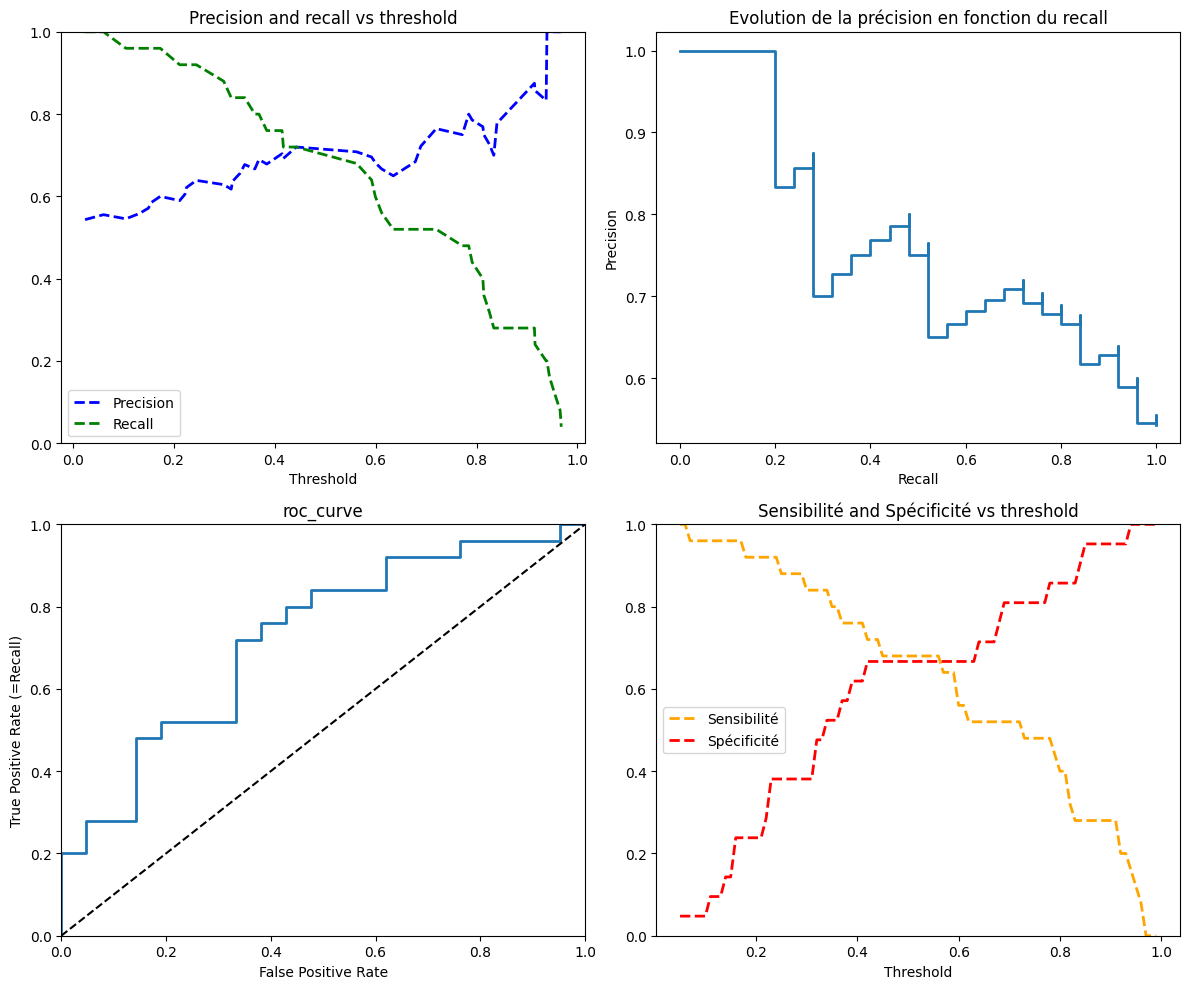

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.69
Sensibilité : 0.52
Spécificité : 0.8095238095238095


In [97]:
# Initialize the model
HI_speci_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)

# Prepare the data for training
X_train_features = X_train.loc[:, liste_col_speci + liste_col_mixte]
X_test_features = X_test.loc[:, liste_col_speci + liste_col_mixte]

# Remove duplicate columns
X_train_features = X_train_features.loc[:, ~X_train_features.columns.duplicated()]
X_test_features = X_test_features.loc[:, ~X_test_features.columns.duplicated()]

# Check the columns after removing duplicates
print("Training columns after removing duplicates:", list(X_train_features.columns))
print("Testing columns after removing duplicates:", list(X_test_features.columns))

# Update categorical_features to match the new number of features
list_type_variable = [col in list_type_variable for col in X_train_features.columns]

# Initialize the model with the updated categorical features
HI_speci_mixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)

# Fit the model
HI_speci_mixte.fit(X_train_features, y_train)

# Reorder columns in X_test to match the order in X_train
X_test_features = X_test_features.loc[:, X_train_features.columns]

# Verify the columns are now aligned
assert list(X_train_features.columns) == list(X_test_features.columns), "Column mismatch between training and testing datasets"

# Predict using the test dataset
pred_bl_speci_mixte = HI_speci_mixte.predict(X_test_features)

# Plot the model results
model_to_plot(HI_speci_mixte, X_test_features, y_test)

# Store the results
resultat_speci_mixte = pd.DataFrame(pd.Series(scores(y_test, pred_bl_speci_mixte)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_mixte.loc['sensibilite', 'XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_mixte.loc['specificité', 'XGB_BL_sensi'])

# Get the best threshold and corresponding scores
dict_speci_mixte = from_model_to_bst_trhld(HI_speci_mixte, X_test_features, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_mixte['best_threshold'])
print('Sensibilité :', dict_speci_mixte['scores']['sensibilite'])
print('Spécificité :', dict_speci_mixte['scores']['specificité'])

### Optimisation : 

##### Sensi :

In [104]:
# Update categorical_features to match the new number of features
list_type_variable = [col in list_type_variable for col in X_train_features.columns]
hi_1_opti_spemixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs_1_spemixte = BayesSearchCV(hi_1_opti_spemixte, param_hi, scoring=sensibilite, random_state=seed)
bs_1_spemixte.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_speci_mixte_1 = HistGradientBoostingClassifier(**dict(bs_1_spemixte.best_params_), random_state=seed, categorical_features=list_type_variable)
tree_speci_mixte_1.fit(X_train.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_speci_mixte_1 = tree_speci_mixte_1.predict(X_test.loc[:,liste_col_speci+liste_col_mixte])
model_to_plot(tree_speci_mixte_1, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_speci_mixte_1 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_mixte_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_mixte_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_mixte_1.loc['specificité','XGB_BL_sensi'])
dict_speci_mixte_1 = from_model_to_bst_trhld(tree_speci_mixte_1, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_mixte_1['best_threshold'])
print('Sensibilité :', dict_speci_mixte_1['scores']['sensibilite'])
print('Spécificité :', dict_speci_mixte_1['scores']['specificité'])

ValueError: categorical_features set as a boolean mask must have shape (n_features,), got: (82,)

##### Spéci :

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


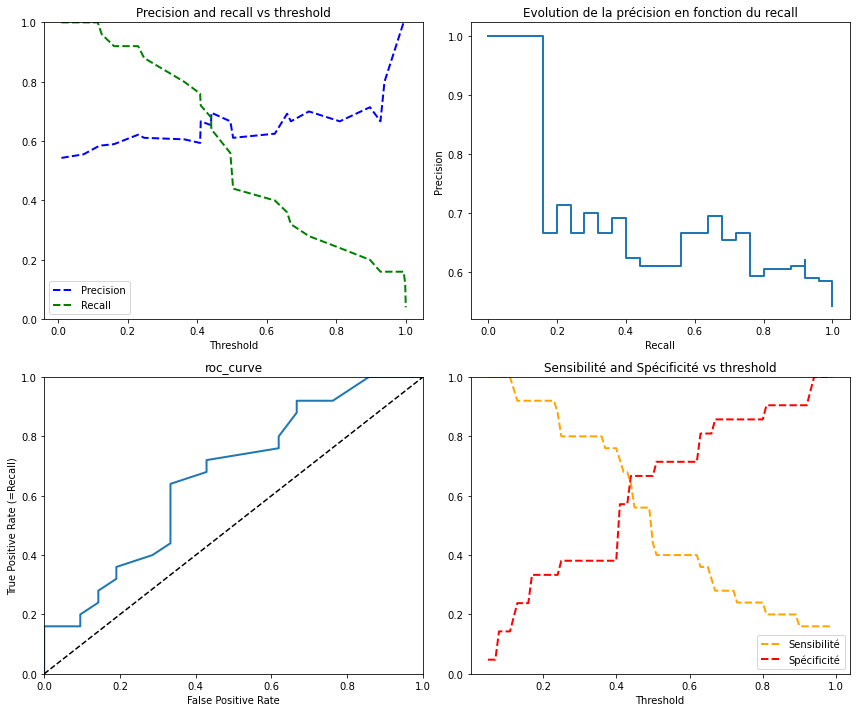

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.63
Sensibilité : 0.36
Spécificité : 0.8095238095238095


In [56]:
hi_2_opti_spemixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs_2_spemixte = BayesSearchCV(hi_2_opti_spemixte, param_hi, scoring=specificite, random_state=seed)
bs_2_spemixte.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_speci_mixte_2 = HistGradientBoostingClassifier(**dict(bs_2_spemixte.best_params_), random_state=seed, categorical_features=list_type_variable)
tree_speci_mixte_2.fit(X_train.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_speci_mixte_2 = tree_speci_mixte_2.predict(X_test.loc[:,liste_col_speci+liste_col_mixte])
model_to_plot(tree_speci_mixte_2, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_speci_mixte_2 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_mixte_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_mixte_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_mixte_2.loc['specificité','XGB_BL_sensi'])
dict_speci_mixte_2 = from_model_to_bst_trhld(tree_speci_mixte_2, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_mixte_2['best_threshold'])
print('Sensibilité :', dict_speci_mixte_2['scores']['sensibilite'])
print('Spécificité :', dict_speci_mixte_2['scores']['specificité'])

##### F1 :

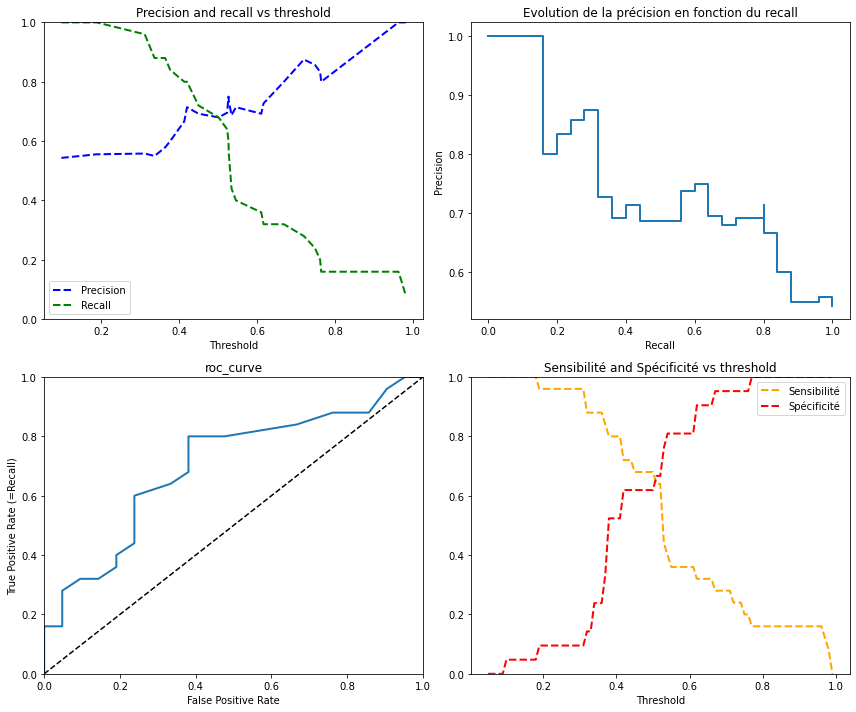

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.54
Sensibilité : 0.4
Spécificité : 0.8095238095238095


In [57]:
hi_3_opti_spemixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs_3_spemixte = BayesSearchCV(hi_3_opti_spemixte, param_hi, scoring='f1', random_state=seed)
bs_3_spemixte.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_speci_mixte_3 = HistGradientBoostingClassifier(**dict(bs_3_spemixte.best_params_), random_state=seed, categorical_features=list_type_variable)
tree_speci_mixte_3.fit(X_train.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_speci_mixte_3 = tree_speci_mixte_3.predict(X_test.loc[:,liste_col_speci+liste_col_mixte])
model_to_plot(tree_speci_mixte_3, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_speci_mixte_3 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_mixte_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5'
     )
print('Sensibilité : ', resultat_speci_mixte_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_mixte_3.loc['specificité','XGB_BL_sensi'])
dict_speci_mixte_3 = from_model_to_bst_trhld(tree_speci_mixte_3, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_mixte_3['best_threshold'])
print('Sensibilité :', dict_speci_mixte_3['scores']['sensibilite'])
print('Spécificité :', dict_speci_mixte_3['scores']['specificité'])

##### Custom :

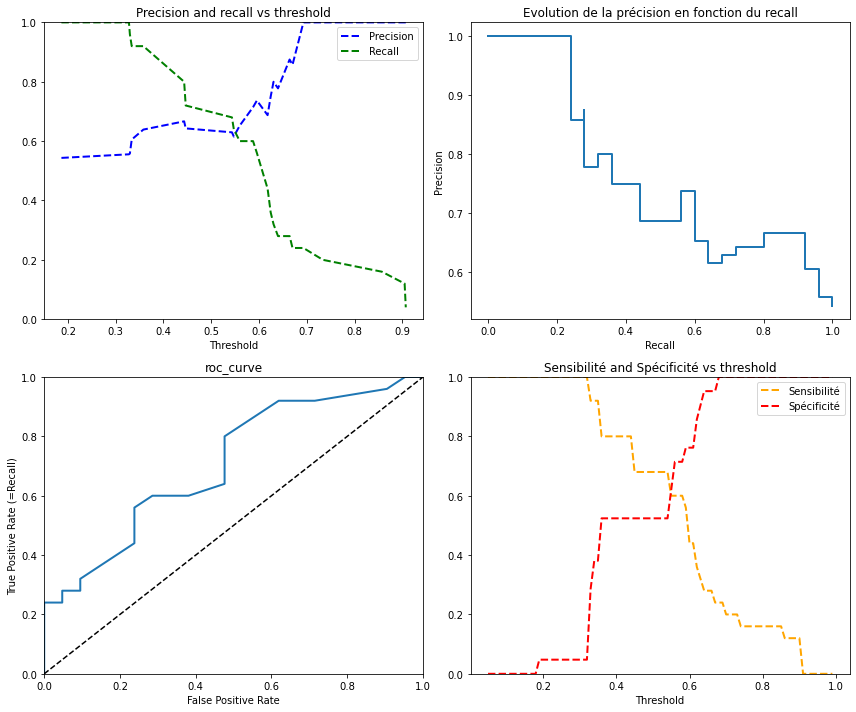

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.62
Sensibilité : 0.36
Spécificité : 0.8571428571428571


In [58]:
hi_4_opti_spemixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs4_spemixte = BayesSearchCV(hi_4_opti_spemixte, param_hi, scoring=scorer, random_state=seed)
bs4_spemixte.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_speci_mixte_4 = HistGradientBoostingClassifier(**dict(bs4_spemixte.best_params_), random_state=seed, categorical_features=list_type_variable)
tree_speci_mixte_4.fit(X_train.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_speci_mixte_4 = tree_speci_mixte_4.predict(X_test.loc[:,liste_col_speci+liste_col_mixte])
model_to_plot(tree_speci_mixte_4, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_speci_mixte_4 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_mixte_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_mixte_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_mixte_4.loc['specificité','XGB_BL_sensi'])
dict_speci_mixte_4 = from_model_to_bst_trhld(tree_speci_mixte_4, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_mixte_4['best_threshold'])
print('Sensibilité :', dict_speci_mixte_4['scores']['sensibilite'])
print('Spécificité :', dict_speci_mixte_4['scores']['specificité'])

##### Mix :

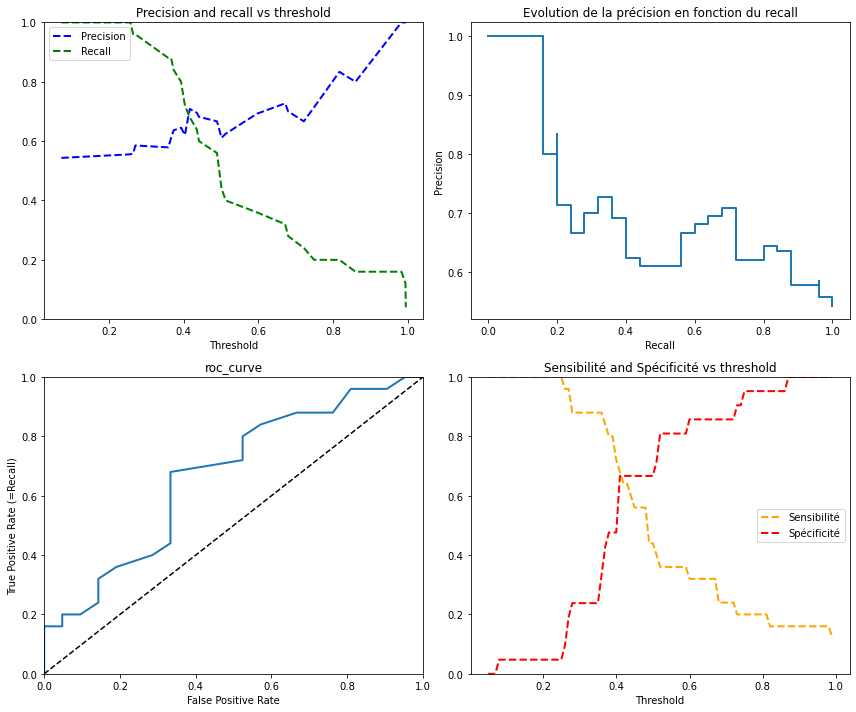

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.52
Sensibilité : 0.36
Spécificité : 0.8095238095238095


In [59]:
hi_5_opti_spemixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs5_spemixte = BayesSearchCV(hi_5_opti_spemixte, param_hi, scoring=mix_recall, random_state=seed)
bs5_spemixte.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_speci_mixte_5 = HistGradientBoostingClassifier(**dict(bs5_spemixte.best_params_), random_state=seed, categorical_features=list_type_variable)
tree_speci_mixte_5.fit(X_train.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_speci_mixte_5 = tree_speci_mixte_5.predict(X_test.loc[:,liste_col_speci+liste_col_mixte])
model_to_plot(tree_speci_mixte_5, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_speci_mixte_5 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_mixte_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_mixte_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_mixte_5.loc['specificité','XGB_BL_sensi'])
dict_speci_mixte_5 = from_model_to_bst_trhld(tree_speci_mixte_5, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_mixte_5['best_threshold'])
print('Sensibilité :', dict_speci_mixte_5['scores']['sensibilite'])
print('Spécificité :', dict_speci_mixte_5['scores']['specificité'])

##### average precision

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


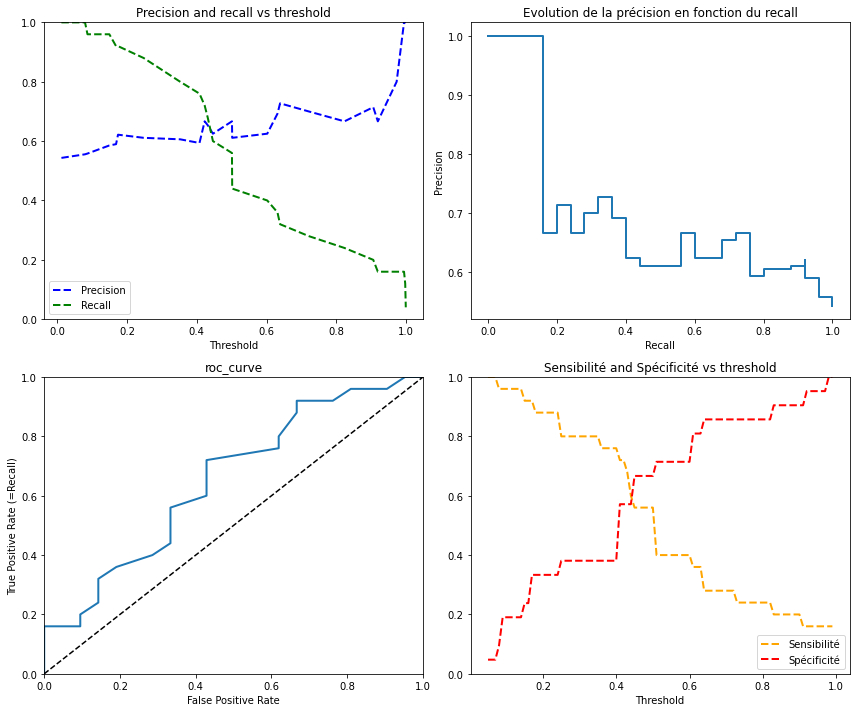

threshold = 0,5
Sensibilité :  0.56
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.61
Sensibilité : 0.36
Spécificité : 0.8095238095238095


In [60]:
hi_6_opti_spemixte = HistGradientBoostingClassifier(random_state=seed, categorical_features=list_type_variable)
bs6_spemixte = BayesSearchCV(hi_6_opti_spemixte, param_hi, scoring='average_precision', random_state=seed)
bs6_spemixte.fit(X_train.loc[:,list(set(liste_col_speci+liste_col_mixte))], y_train)
tree_speci_mixte_6 = HistGradientBoostingClassifier(**dict(bs6_spemixte.best_params_), random_state=seed, categorical_features=list_type_variable)
tree_speci_mixte_6.fit(X_train.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_speci_mixte_6 = tree_speci_mixte_6.predict(X_test.loc[:,liste_col_speci+liste_col_mixte])
model_to_plot(tree_speci_mixte_6, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_speci_mixte_6 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_mixte_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_mixte_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_mixte_6.loc['specificité','XGB_BL_sensi'])
dict_speci_mixte_6 = from_model_to_bst_trhld(tree_speci_mixte_6, X_test.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_mixte_6['best_threshold'])
print('Sensibilité :', dict_speci_mixte_6['scores']['sensibilite'])
print('Spécificité :', dict_speci_mixte_6['scores']['specificité'])

# Fin 

# A compléter :

## Recherche des meilleures colonnes : 

In [ ]:
######### Reste à faire pour le HGB #########

def get_cat_list(data, list_of_columns):
    '''
    A vérifier
    '''
    list_type_variable = []
    for name, series in data.loc[:,list_of_columns].iteritems():
        if len(series.value_counts())<=2:
            list_type_variable.append(True)
        else :
            list_type_variable.append(False)
            
    return list_type_variable


def ML_opti_recueil_HGB(X_train, X_test, y_train, y_test, liste_col, model_to_train, seuil_FP, seuil_FN):
    '''
    take a Train/test split and a list of column for fit a baseline ML algorithm and try to improve it, column bu column.
    input:
    X_train : training features pd.DataFrame is expected
    X_test : test features pd.DataFrame is expected
    y_train : training labels pd.DataFrame is expected
    y_test : test labels pd.DataFrame is expected
    liste_col : liste of columns from the train, will be the baseline for ML
    model_to_train
    seuil_FP
    seuil_FN
    
    Return :
    Dictionary with fitted model, metrics' results, predictions
    
    '''
############# Implémenter la recherche de colonne_cat pour continuer ########################
    
    
    
    
    
    
    # Initialisation : 
    dict_best_set = {}
    best_results ={}
    list_columns_to_try = filtre_list(list(X_train.columns), liste_col)
    y_pred_baseline, model_baseline  = fit_method(model_to_train, X_train, X_test, y_train, liste_col)
    dict_score_baseline = scores(y_test, y_pred_baseline) 
    check_baseline(dict_score_baseline, seuil_FP, seuil_FN)
    best_set = liste_col
    best_results['results'] = dict_score_baseline
    best_results['set_col'] = best_set
    
    # Loop for optimize the ML :
    for col in list_columns_to_try:
        if check_corr_col(col, best_set)==True:
            print(len(best_set+[col]))
            y_pred, model  = fit_method(model_to_train, X_train, X_test, y_train, best_set+[col])
            dict_score = scores(y_test, y_pred)
            if check_best_results(dict_score, seuil_FP, seuil_FN): ##### TO DO !!!!!!
                best_set = best_set + [col]
                best_results['results'] = dict_score
                best_results['model'] = model
                dict_best_set[f'resultat_{len(dict_best_set.keys())}'] = {'set_col':best_set, 'resultat':dict_score, 'model':model}
        else:
            continue
    
    
    return best_results, dict_best_set, y_pred

# Feature selection : 

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector